In [1]:
import pandas as pd, glob, scipy as sci, pandas as pd, numpy as np, copy
from matplotlib import pyplot as plt
from numpy import pi,cos,exp,square, sqrt, imag, shape
from scipy.special import wofz

In [2]:
# reading and sorting files into reference and transmission data
data_files = glob.glob('/kaggle/input/ftir-thin-film/*.dpt')
temp = [x for x in data_files if '0_reflx.' in x]
reflx_data = [temp[0], temp[3], temp[1], temp[2]]
reflx_glass = pd.read_csv([x for x in data_files if 'glass_reflx' in x][0])
reflx_refr = pd.read_csv([x for x in data_files if 'refr_reflx.' in x][0])
trans_data = [x for x in data_files if '0_trans' in x]
trans_refr = pd.read_csv([x for x in data_files if 'refr_reflx' in x][0])
trans_glass = pd.read_csv([x for x in data_files if 'glass_trans' in x][0])

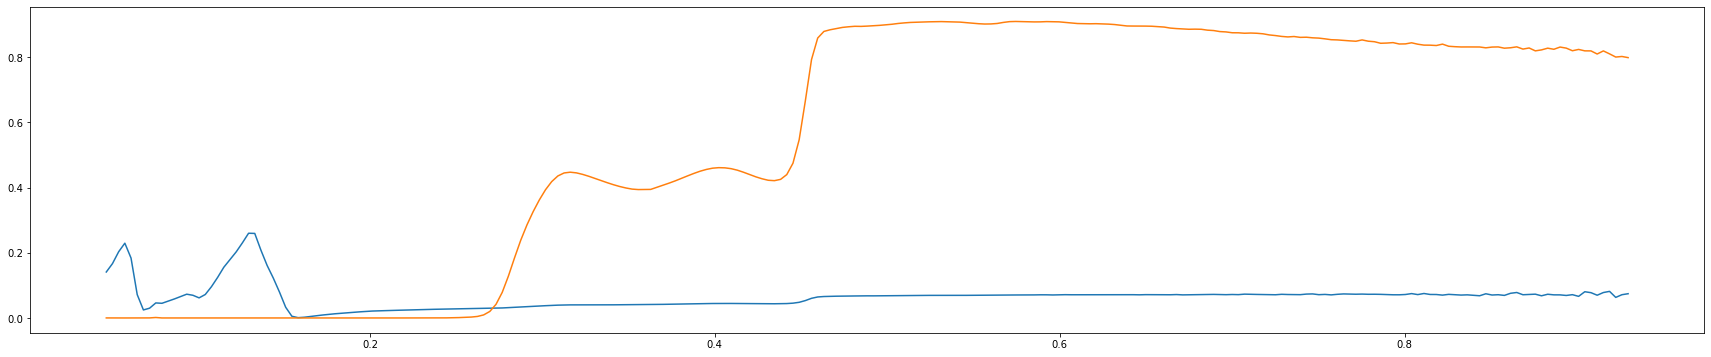

In [3]:
SHORT=2800
fig = plt.figure(figsize=(30,6))
yreflx = reflx_glass.iloc[:,1] / reflx_refr.iloc[:,1] 
yreflx = yreflx[::15]
x = reflx_glass.iloc[:,0]
x = x[::15]
yreflx_first = reflx_glass.iloc[:,1][SHORT:] / reflx_refr.iloc[:,1][SHORT:] 
xshort = reflx_glass.iloc[:,0][SHORT:]
plt.plot(x, yreflx)

ytrans = trans_glass.iloc[:,1] / trans_refr.iloc[:,1] 
ytrans = ytrans[::15]
ytrans_first  = trans_glass.iloc[:,1][SHORT:] / trans_refr.iloc[:,1][SHORT:] 
plt.plot(x, ytrans)

# First part Thick

# **Most Recent**

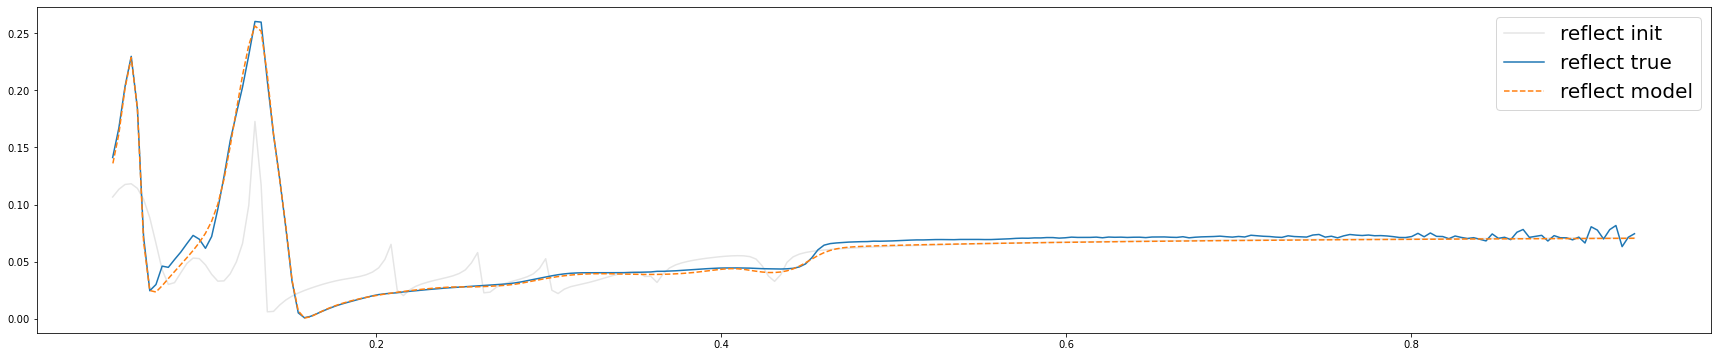

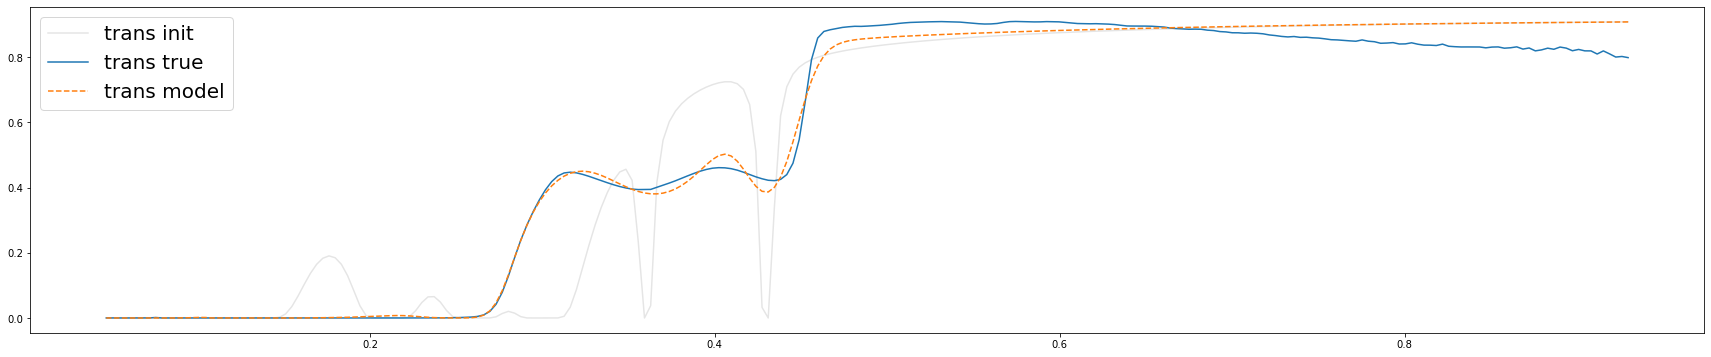

100 [1.16517966e-03 4.35685347e-02 9.00521824e-03 2.13215579e-02
 1.93025193e-03 5.71106836e-02 6.38634463e-03 2.09097250e-03
 1.94194204e-03 1.39545168e-01 1.91574699e-06 7.84668811e-03
 5.57725910e-03 1.26058236e-01 3.96558318e-04 5.86142476e-03
 7.40084294e-04 1.65742319e-01 1.28747396e-03 6.37611495e-02
 1.57980083e-04 2.49777820e-01 1.41579666e-03 1.47551375e-02
 2.52747211e-05 2.51904762e-01 1.00204217e-03 6.77583135e-03
 5.47159961e-05 3.69756774e-01 1.49909299e-12 3.37764834e-02
 1.95193649e-05 4.32018216e-01 1.18969824e-07 1.33225285e-02
 2.00165713e-02]


In [4]:
DONE = False
def hobb(param,Energ):
    #  Dielectric function calculation - Harmonic Oscilator Brendel, Bormann
    #  https://en.wikipedia.org/wiki/Brendel%E2%80%93Bormann_oscillator_model
    #  https://github.com/polyanskiy/refractiveindex.info-scripts/blob/master/scripts/Rakic%201998%20-%20Be%20(BB%20model).py
    #  input parameters:  vector [A, E0, Gamma, Sigma]
    #      E - photon energy [eV]
    # output parameters:  Complex dielectric function 
    #                           - vector corresponding to Energy
    #                           - imaginary part is negative
    param = np.array(param[:-1])
    num_oscilators = int(len(param)/4)
    param = param.reshape(num_oscilators,4).transpose() 
    Energ = np.array(Energ)
    Energ = np.tile(Energ, (num_oscilators,1)).transpose()
    A=param[0]
    E0=param[1]
    Γ=param[2]
    σ=param[3]
    π = pi
    
    ak = sqrt(Energ**2+1j*Energ*Γ)
    ak[ak == 1j*0] = 0.000001*1j
    assert (imag(ak)>0).all
    result = 1j*sqrt(pi/2)*A/2/σ/ak
    permitivity = result * (wofz((ak-E0)/sqrt(2)/σ) + wofz((ak+E0)/sqrt(2)/σ))
    permitivity = np.sum(permitivity, axis =1)
    return permitivity

def thick_layer_hobb(p, energy, R, T):
    Rdiff = thick_reflect_hobb(energy, p) - R
    Tdiff = thick_trans_hobb(energy, p) - T
    return np.concatenate((Tdiff, Rdiff))

def thick_reflect_hobb(wavnum, p):
    d = p[-1]
    epsilon = hobb(p, wavnum) +2.2
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    R_01 = square(abs((1 - n_glass)/(1 + n_glass)))
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = square(abs(2/(1+n_glass)))
    T_10 = square(abs(2*n_glass/(1+n_glass)))
    exponent = exp(-8*pi*wavnum*10**7/1240*extinct*d)
    return R_01 + T_01*R_12*T_10*exponent/(1-square(R_12)*exponent)

def thick_trans_hobb(wavnum, p):
    d = p[-1]
    epsilon = hobb(p, wavnum) +2.2
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = square(abs(2/(1+n_glass)))
    T_12 = square(abs(2*n_glass/(1+n_glass)))
    exponent1 = exp(-4*pi*wavnum*10**7/1240*extinct*d)
    exponent2 = exp(-8*pi*wavnum*10**7/1240*extinct*d)
    Trans = T_01*T_12*exponent1/(1-square(R_12)*exponent2) 
    #print(Trans.dtype)
    return Trans

init_params = []
init_params.extend([0.001,0.06,0.001,0.008,
                    0.001,0.07,0.001,0.008,
                    0.001,0.10,0.001,0.008,
                    0.002,0.13,0.004,0.0008,
                    0.001,0.21,0.004,0.0008,
                    0.001,0.26,0.004,0.0008,
                    0.001,0.3,0.004,0.0008,
                    0.0001,0.36,0.0009,0.0008,
                    0.0001,0.43,0.0009,0.0008,
                   ])
d = 0.02
init_params.append(d)

upper_bounds = np.full(len(init_params)-1, np.inf)
lower_bounds = np.zeros(len(init_params)-1)
bounds = [(np.append(lower_bounds,(0.02))),(np.append(upper_bounds,(0.6)))]
from scipy.optimize import least_squares
thick_res = least_squares(thick_layer_hobb,x0=init_params, args=(x, yreflx, ytrans), bounds = bounds, max_nfev = 100)
DONE =  True

#plotting reflectance
fig = plt.figure(figsize=(30,6))
plt.plot(x, thick_reflect_hobb(x,init_params), label='reflect init', alpha=0.1, color='black')
plt.plot(x, yreflx, label='reflect true')
plt.plot(x, thick_reflect_hobb(x,thick_res.x), label = 'reflect model', linestyle = 'dashed')
plt.legend(fontsize=20)
plt.show()

#plotting transmittance
fig = plt.figure(figsize=(30,6))
plt.plot(x, thick_trans_hobb(x,init_params),label='trans init', alpha=0.1, color = 'black')
plt.plot(x, ytrans, label='trans true')
plt.plot(x, thick_trans_hobb(x,thick_res.x), label = 'trans model',linestyle = 'dashed')
plt.legend(fontsize=20)
plt.show()
print(thick_res.nfev, thick_res.x)

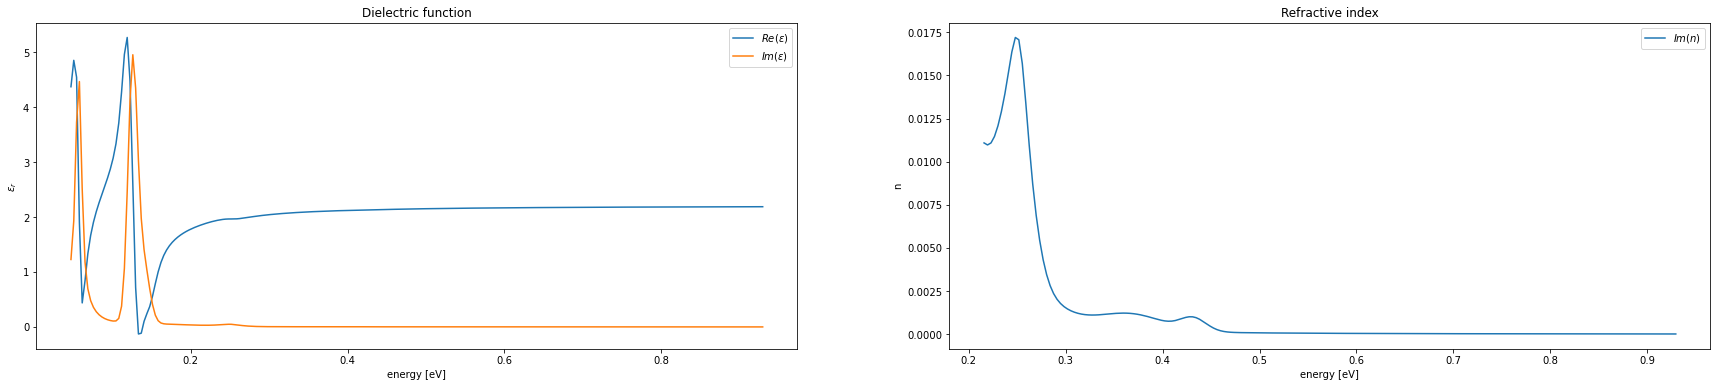

In [5]:
# dataframe
#osci_df = pd.DataFrame(columns=['A[eV]','O[eV]','G[eV]'], index=range(L+2))
#for index in range(L+2):
 #   osci_df.loc[index] = pd.Series({'A[eV]':thick_res_first.x[index*3], 'O[eV]':thick_res_first.x[index*3+1], 'G[eV]':thick_res_first.x[index*3+2]})
#osci_df = osci_df.astype('float64')
#osci_df = osci_df.style.format(precision=3) 
#display(osci_df)

## displaying optical characteristics for the glass substrate
epsilon = hobb(thick_res.x, x) +2.2
n_glass = sqrt(epsilon)
#plotting dielectric function
fig = plt.figure(figsize=(30,6))
plt.subplot(1,2,1)
plt.plot(x, np.real(epsilon), label='$Re(\epsilon)$')
plt.plot(x, np.imag(epsilon), label='$Im(\epsilon)$')
plt.legend()
plt.xlabel("energy [eV]")
plt.ylabel("$\epsilon_r$")
plt.title('Dielectric function')
plt.savefig('Dielectric.png')

# plotting refractive index
plt.subplot(1,2,2)
#plt.plot(x[:200], np.real(n_glass)[:200], label='$Re(n)$')
plt.plot(x[:200], np.imag(n_glass)[:200], label='$Im(n)$')
plt.legend()
plt.xlabel("energy [eV]")
plt.ylabel("n")
plt.title('Refractive index')
plt.savefig('Refractive.png')
#print(np.real(n_glass))

# First part interference

[2e-11, 2.2, 0.016, 1.25, 0.006, 0.3, 1e-10, 0.029, 0.0012, 0.4, 1e-14, 0.0016, 7.3e-08, 0.6, 1e-10, 0.0835, 1.77e-08, 0.83, 1e-10, 0.16, 0.0032, 0.0032, 0.0029, 0.0026]


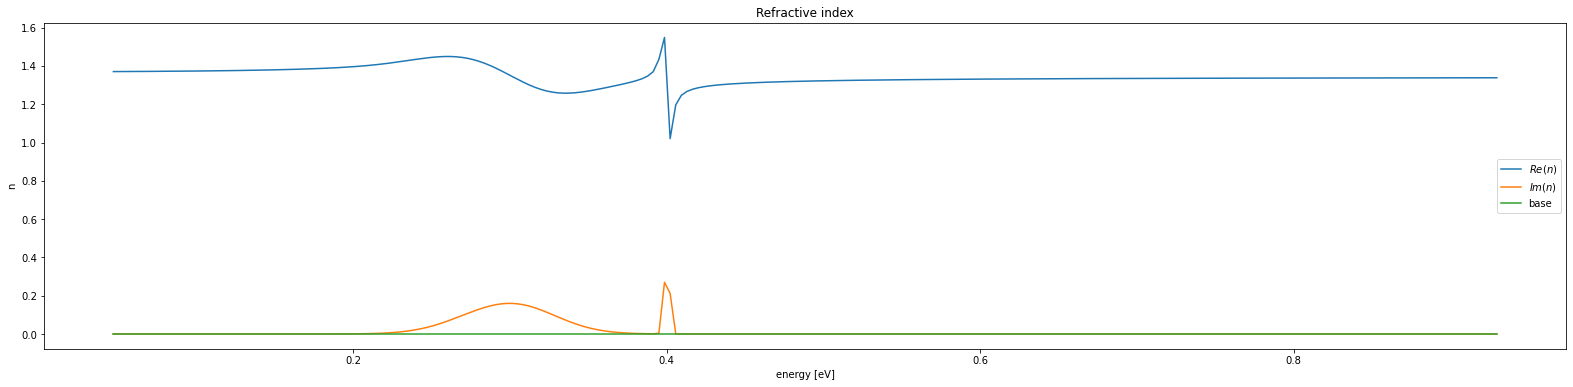

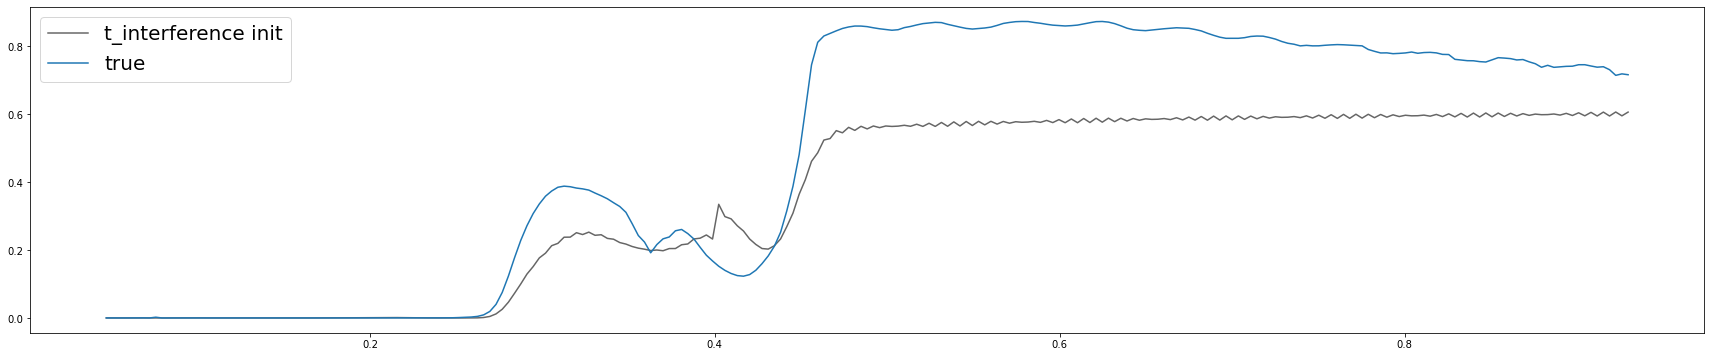

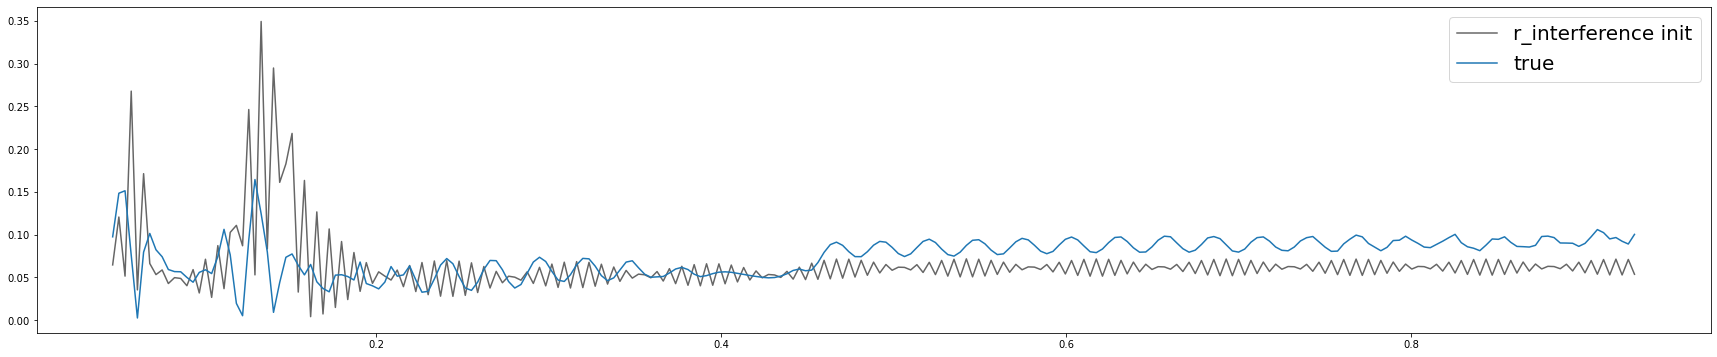

[2e-11, 2.2, 0.016, 1.25, 0.006, 0.3, 1e-10, 0.029, 0.0012, 0.4, 1e-14, 0.0016, 7.3e-08, 0.6, 1e-10, 0.0835, 1.77e-08, 0.83, 1e-10, 0.16, 0.0032, 0.0032, 0.0029, 0.0026]


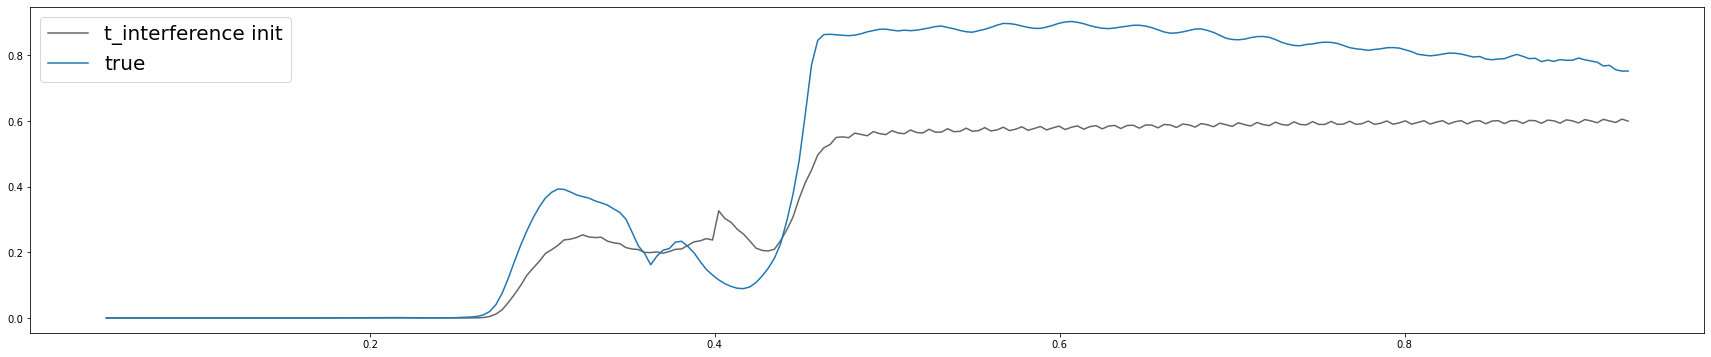

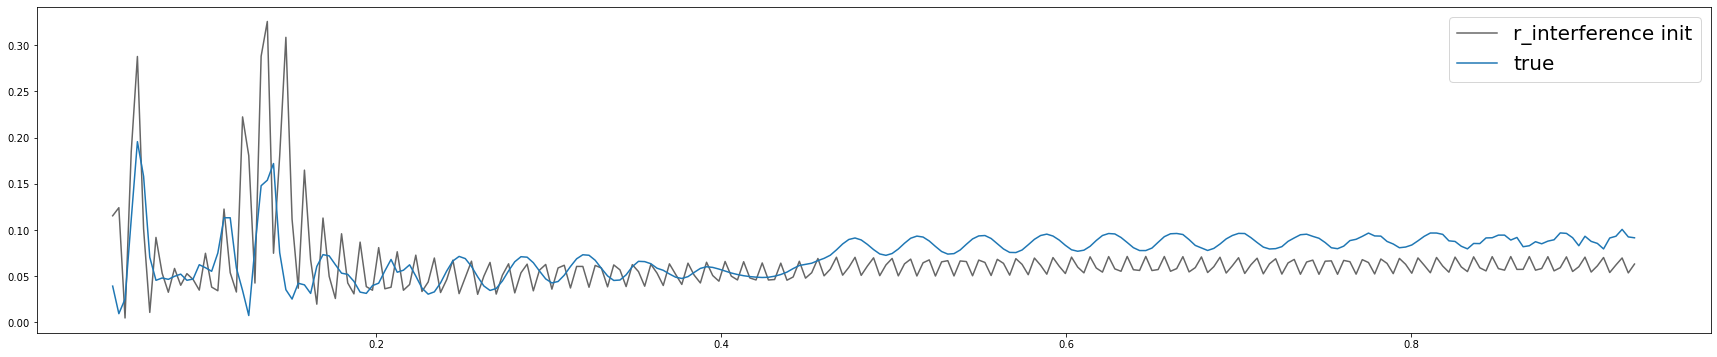

[2e-11, 2.2, 0.016, 1.25, 0.006, 0.3, 1e-10, 0.029, 0.0012, 0.4, 1e-14, 0.0016, 7.3e-08, 0.6, 1e-10, 0.0835, 1.77e-08, 0.83, 1e-10, 0.16, 0.0032, 0.0032, 0.0029, 0.0026]


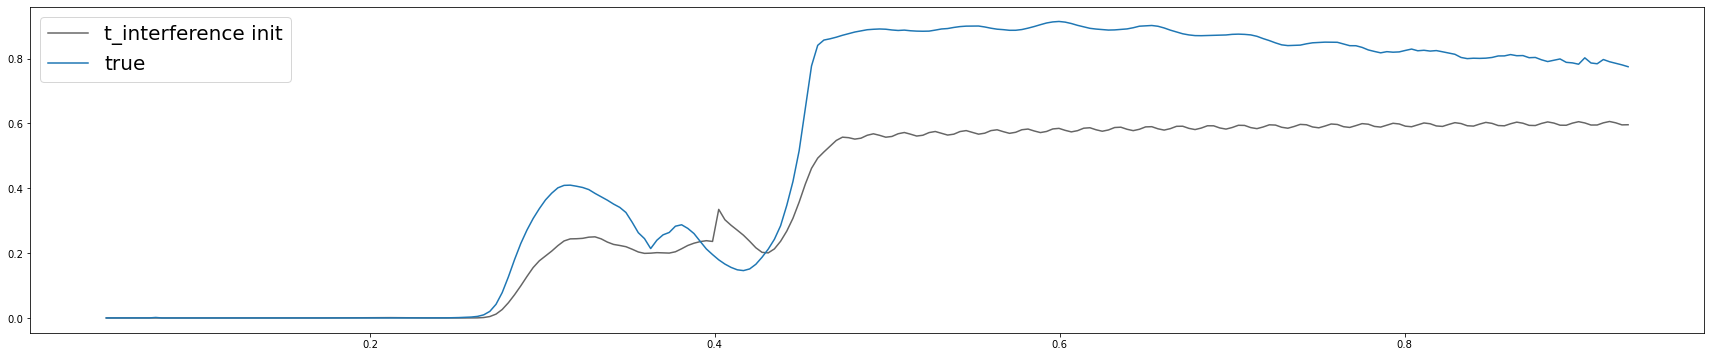

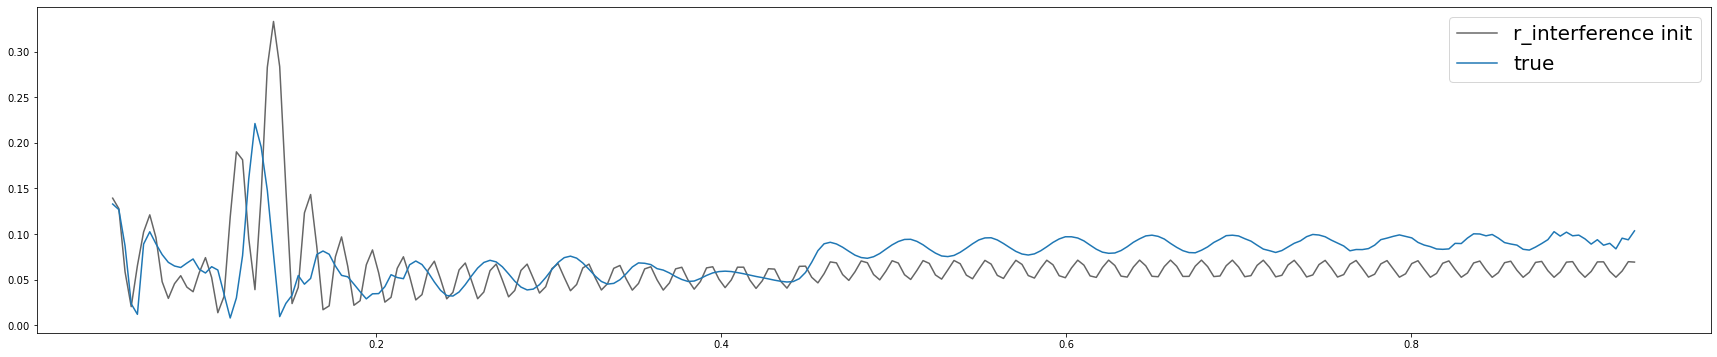

[2e-11, 2.2, 0.016, 1.25, 0.006, 0.3, 1e-10, 0.029, 0.0012, 0.4, 1e-14, 0.0016, 7.3e-08, 0.6, 1e-10, 0.0835, 1.77e-08, 0.83, 1e-10, 0.16, 0.0032, 0.0032, 0.0029, 0.0026]


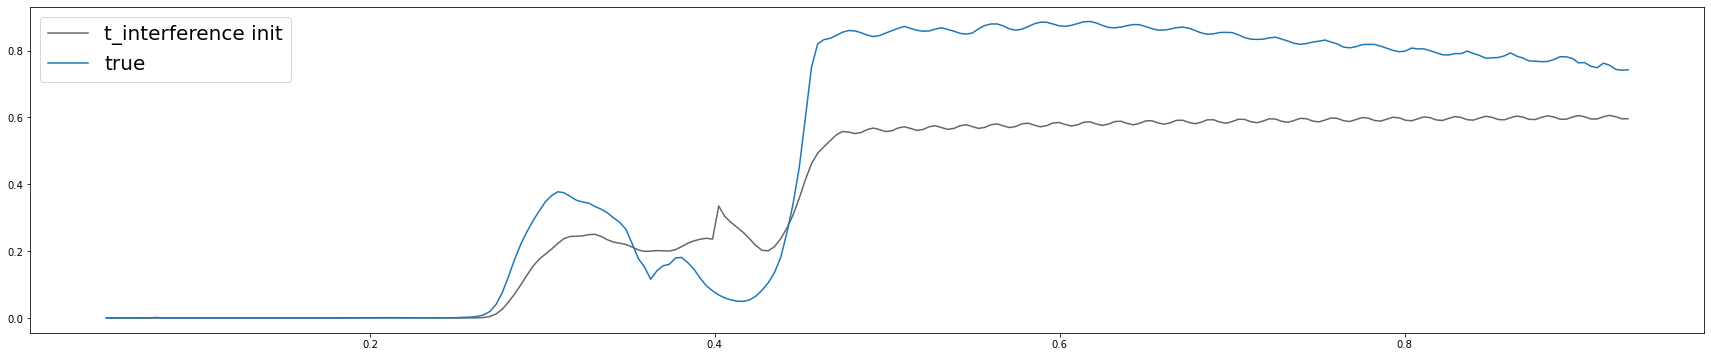

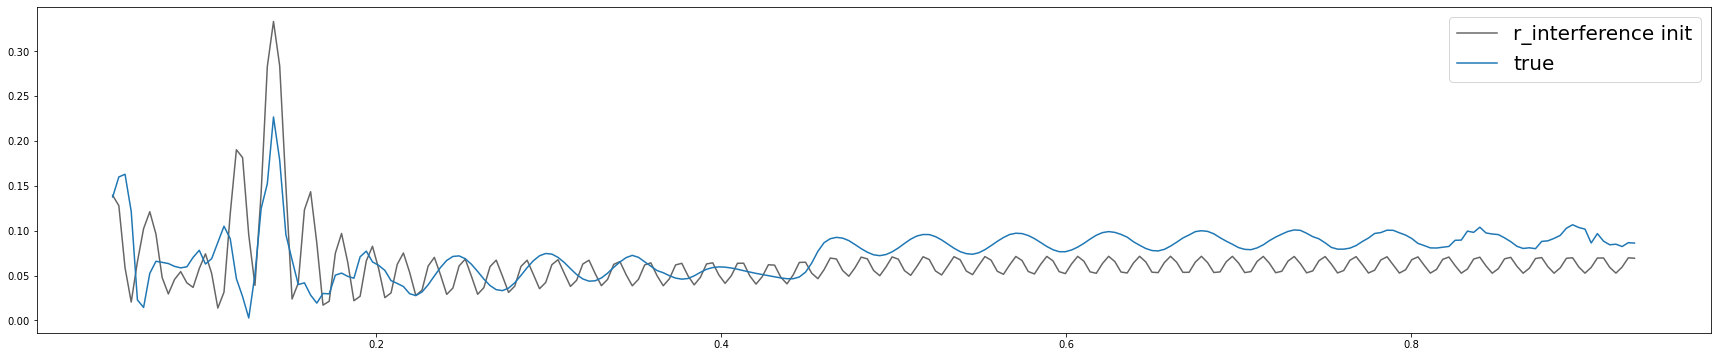

##################################### TURN 0 ######################################
[8.93896016e-11 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


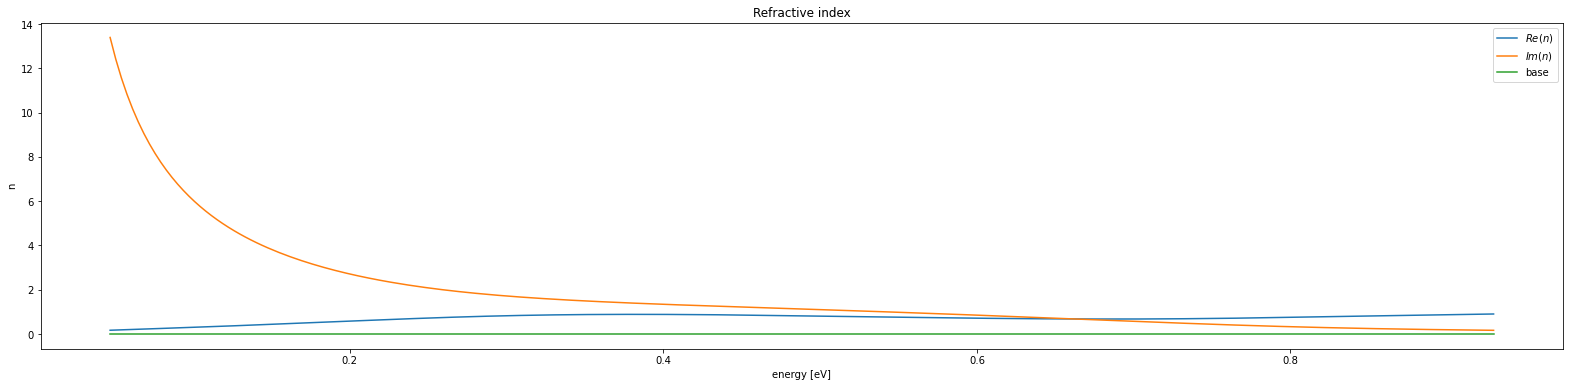

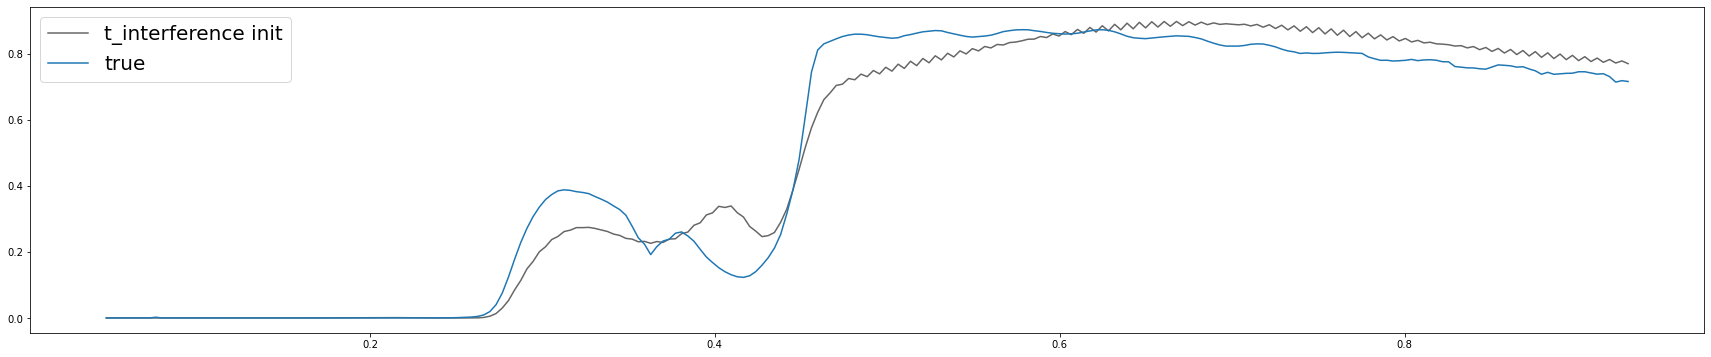

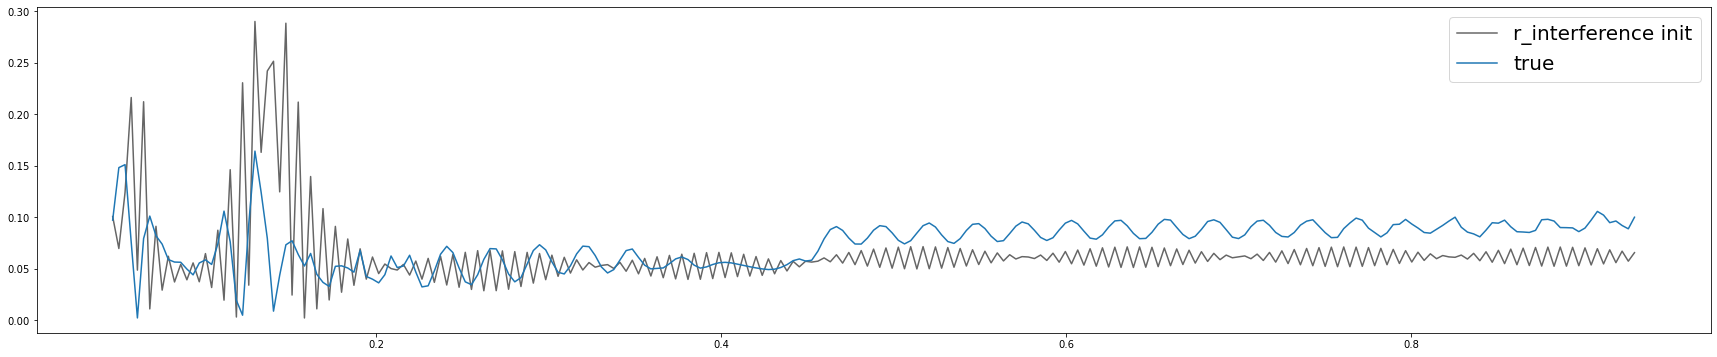

[8.93896016e-11 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


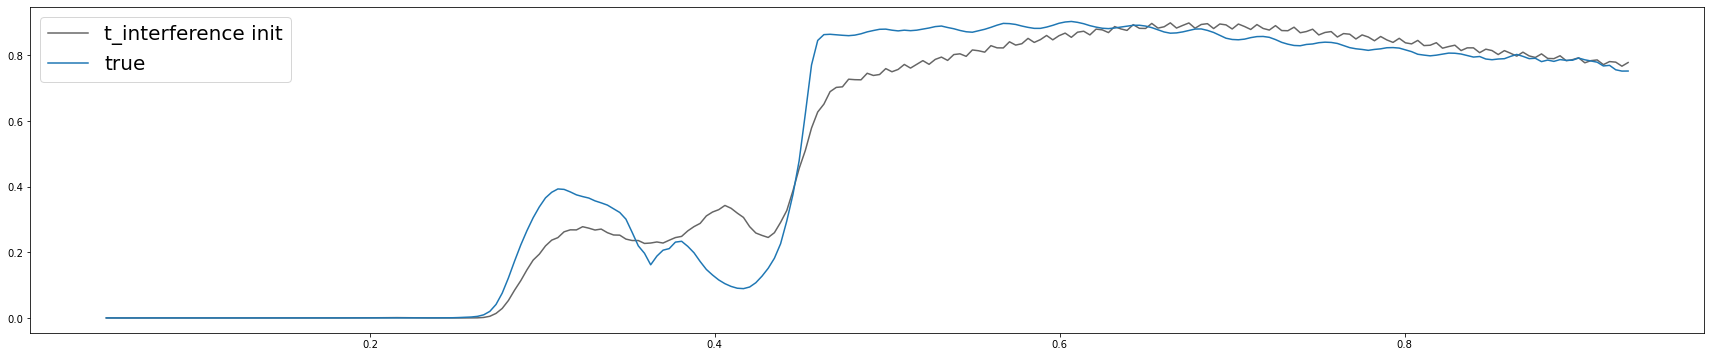

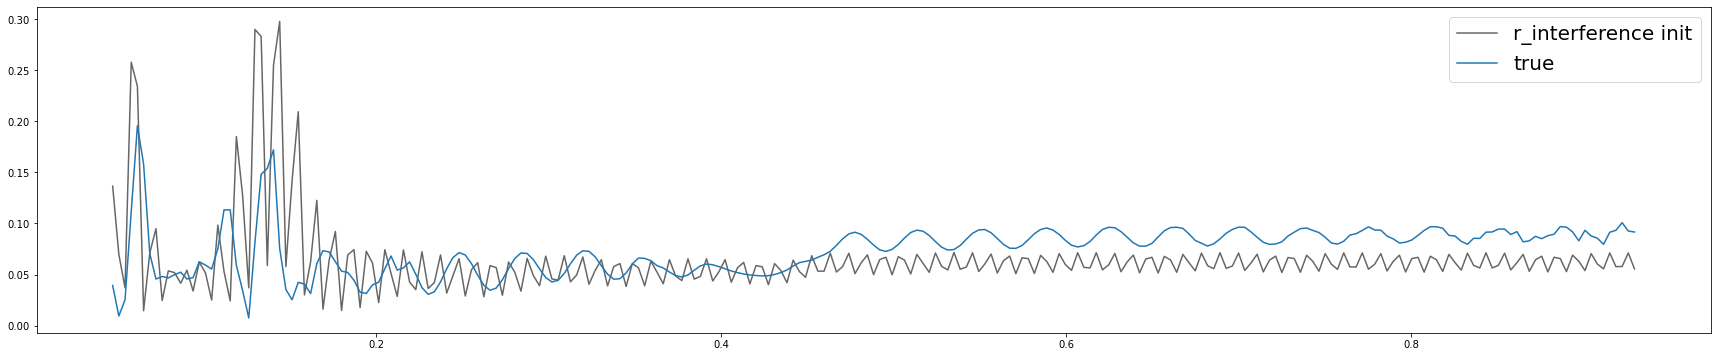

[8.93896016e-11 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


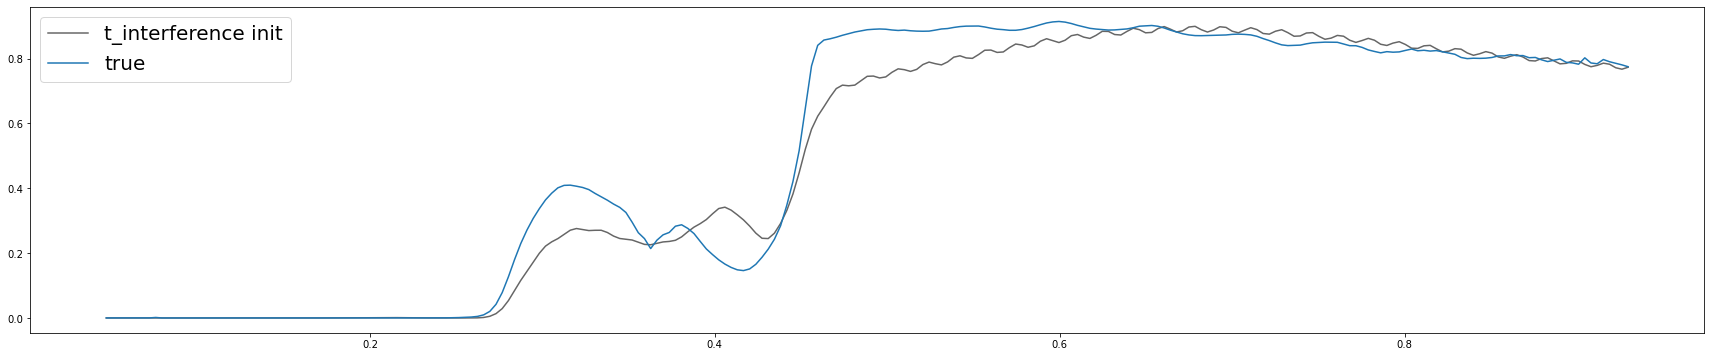

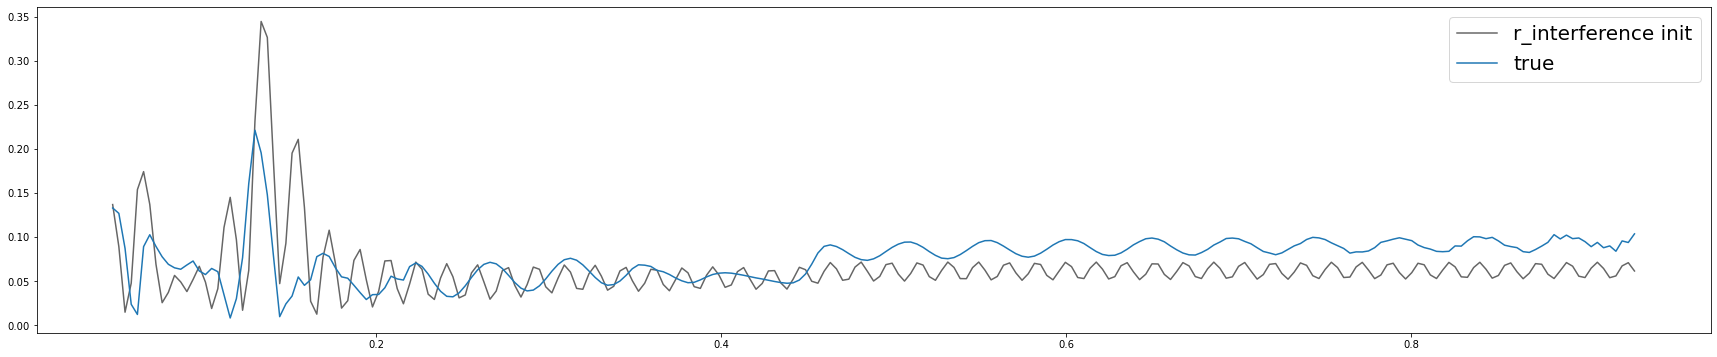

[8.93896016e-11 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


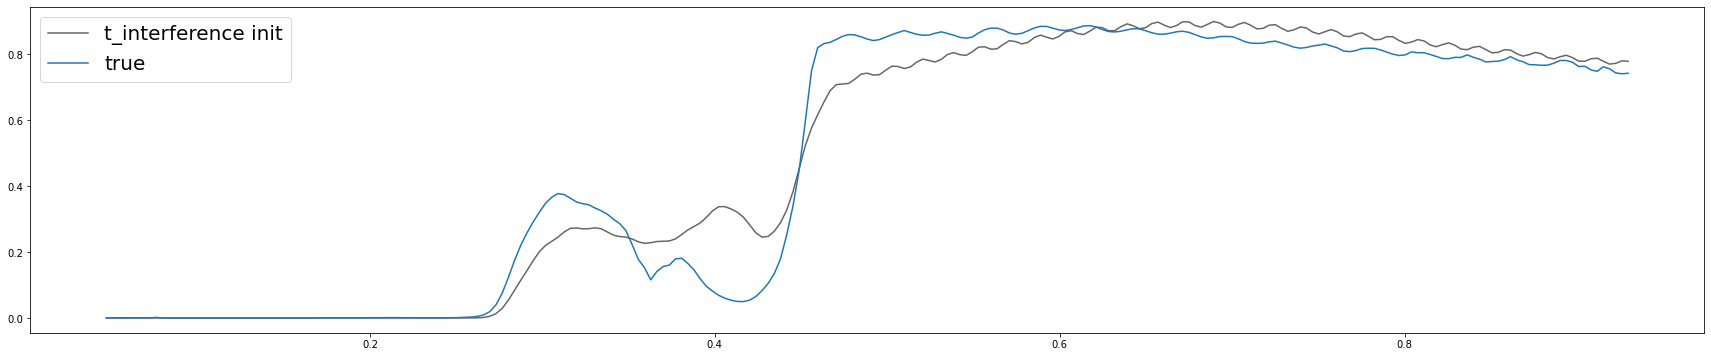

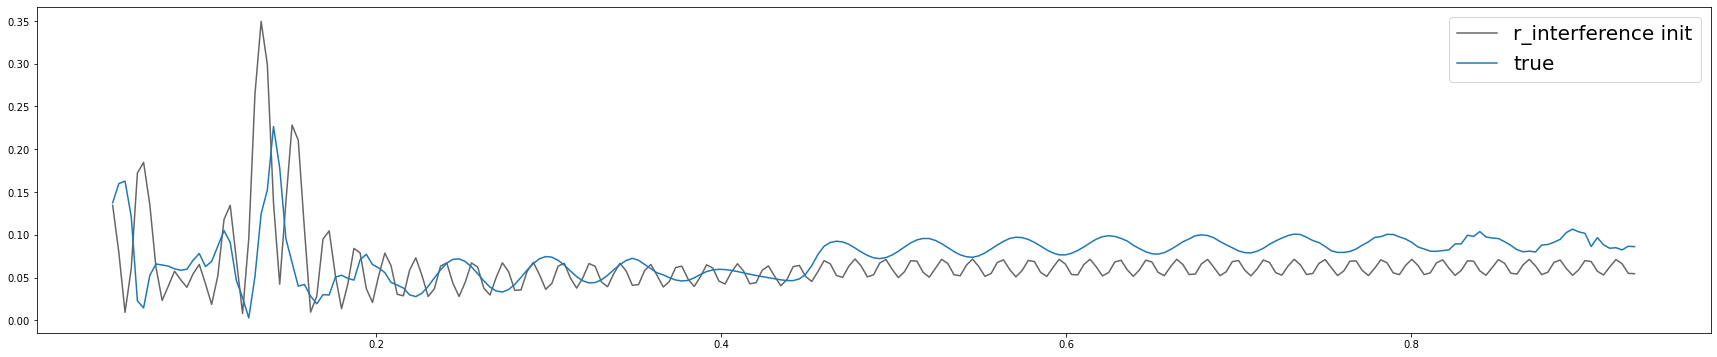

##################################### TURN 1 ######################################
[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


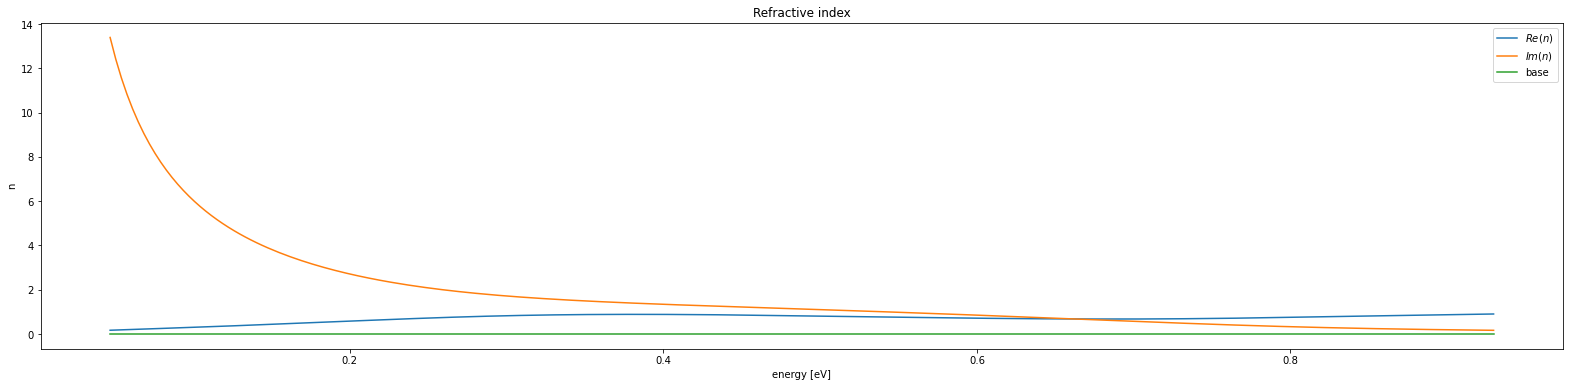

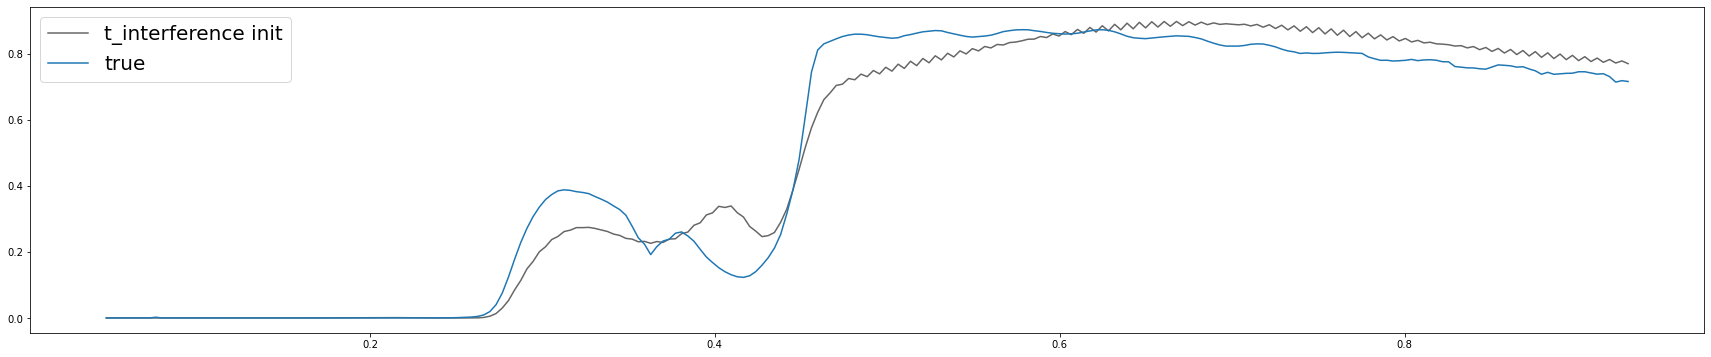

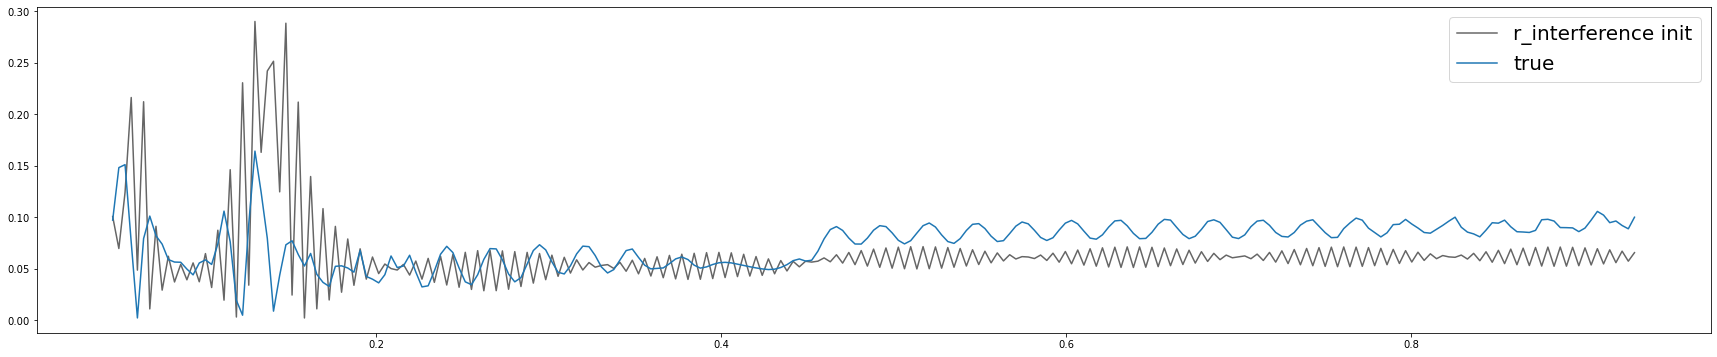

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


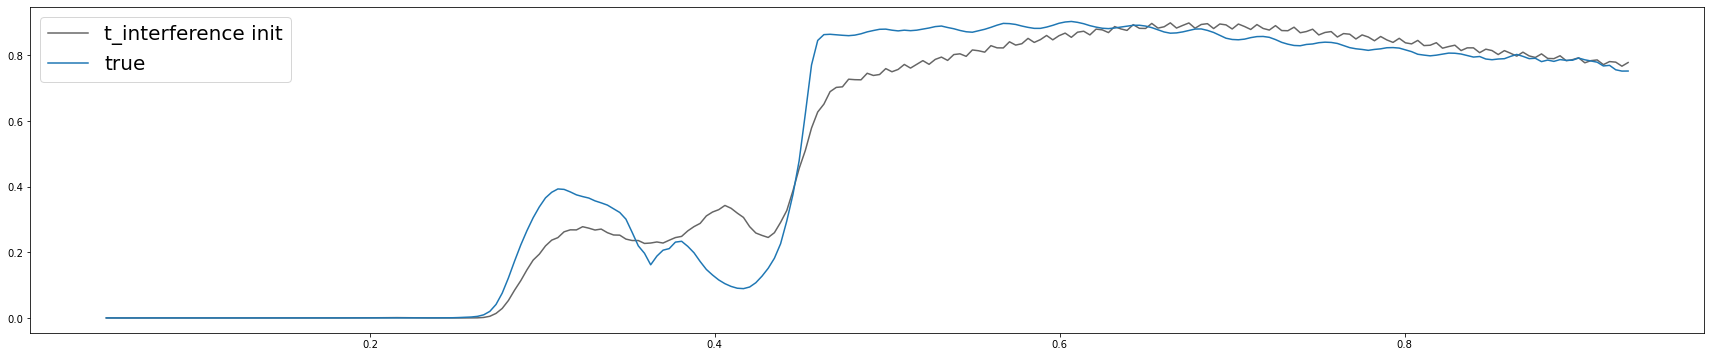

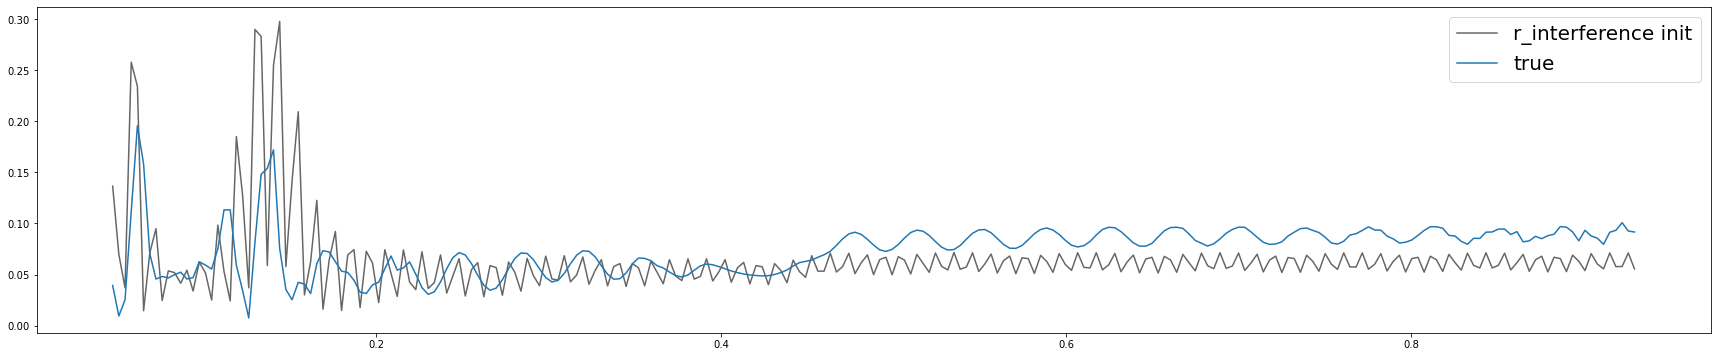

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


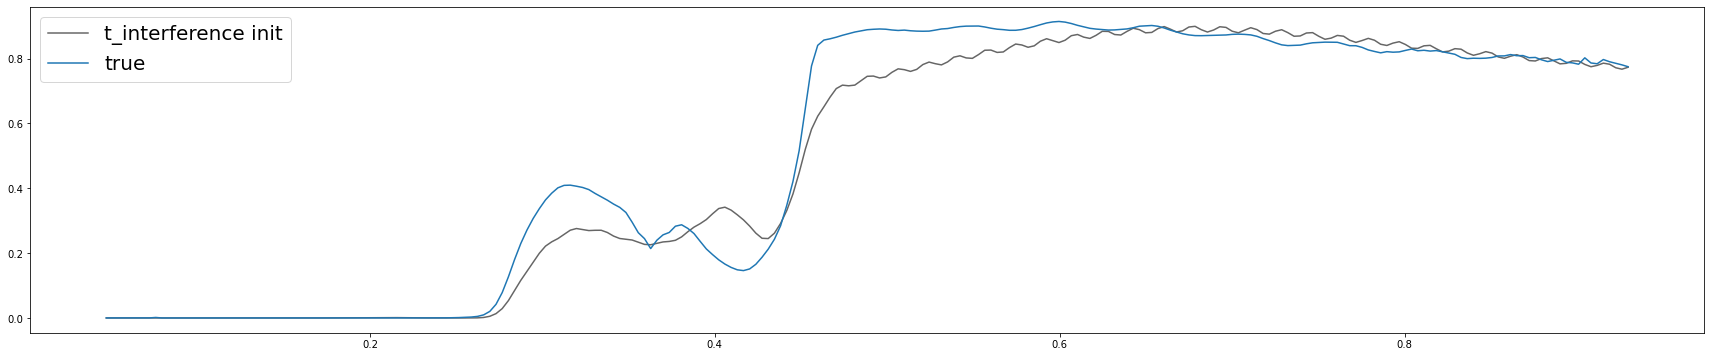

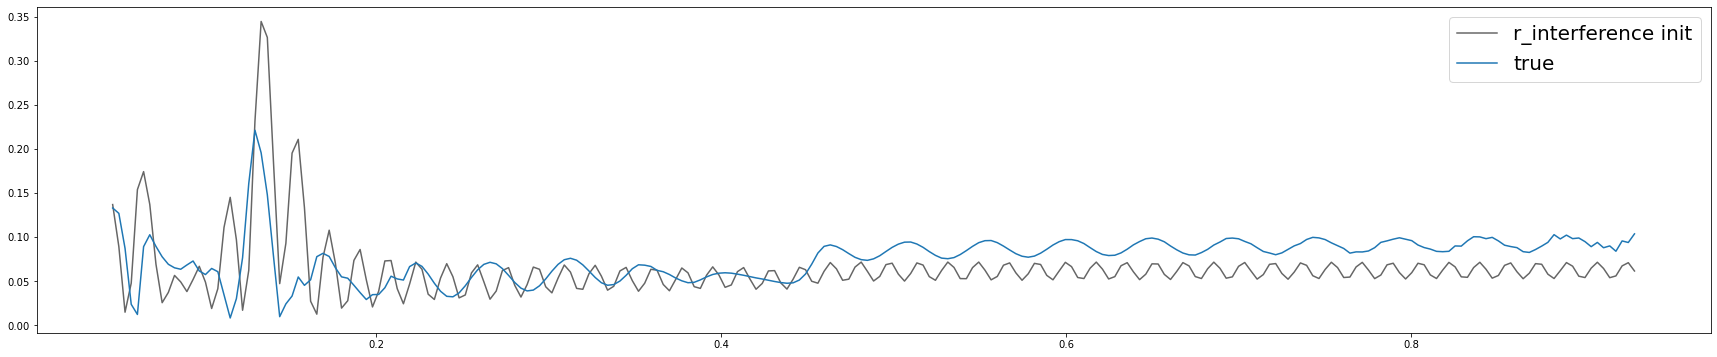

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


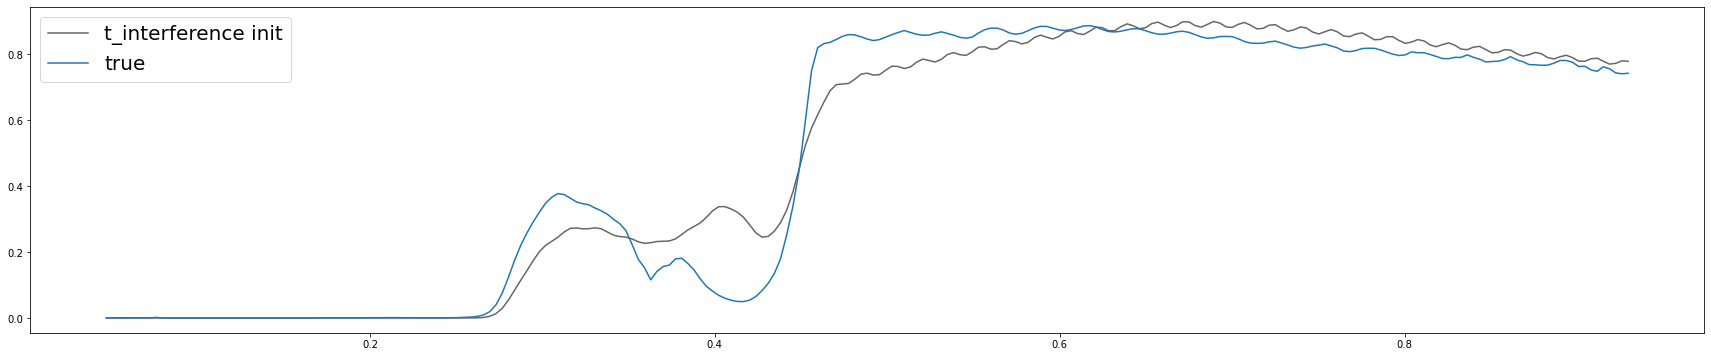

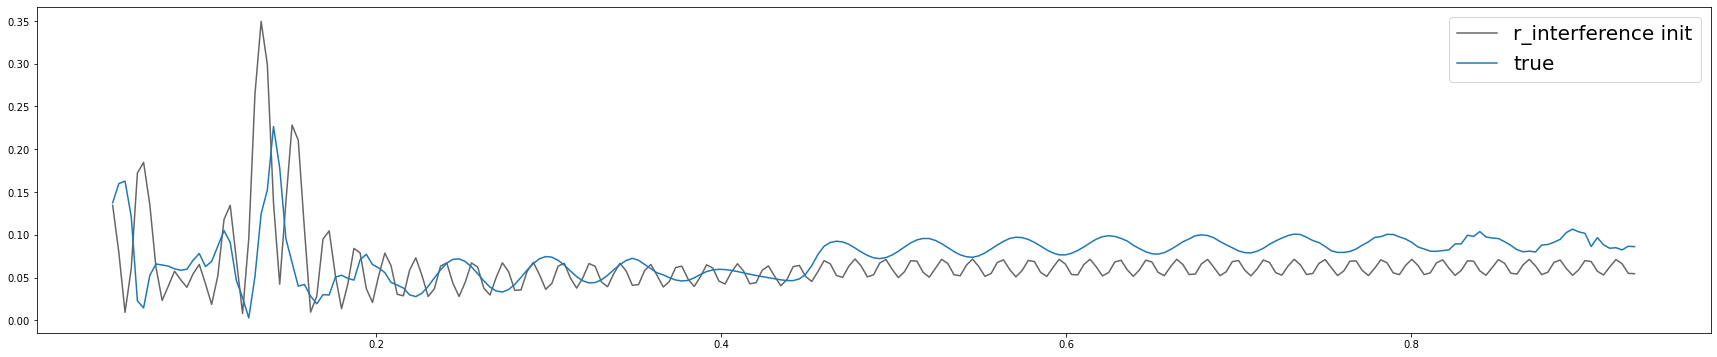

##################################### TURN 2 ######################################
[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


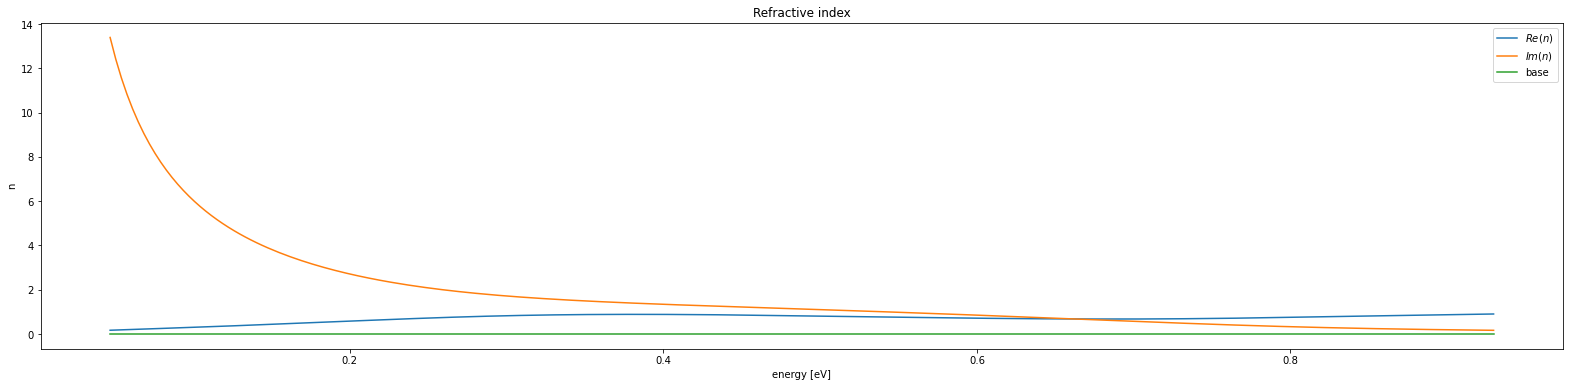

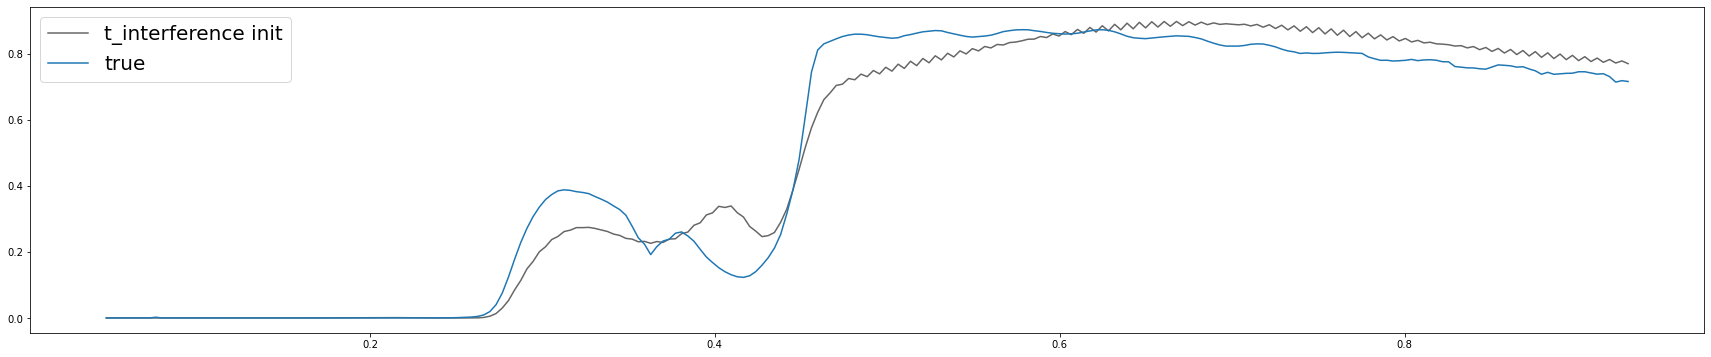

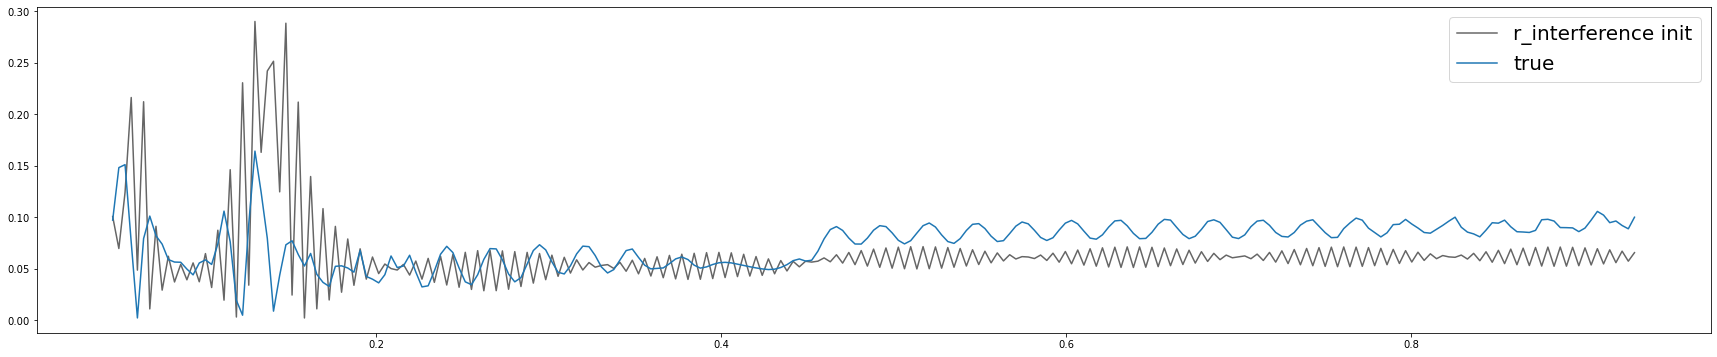

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


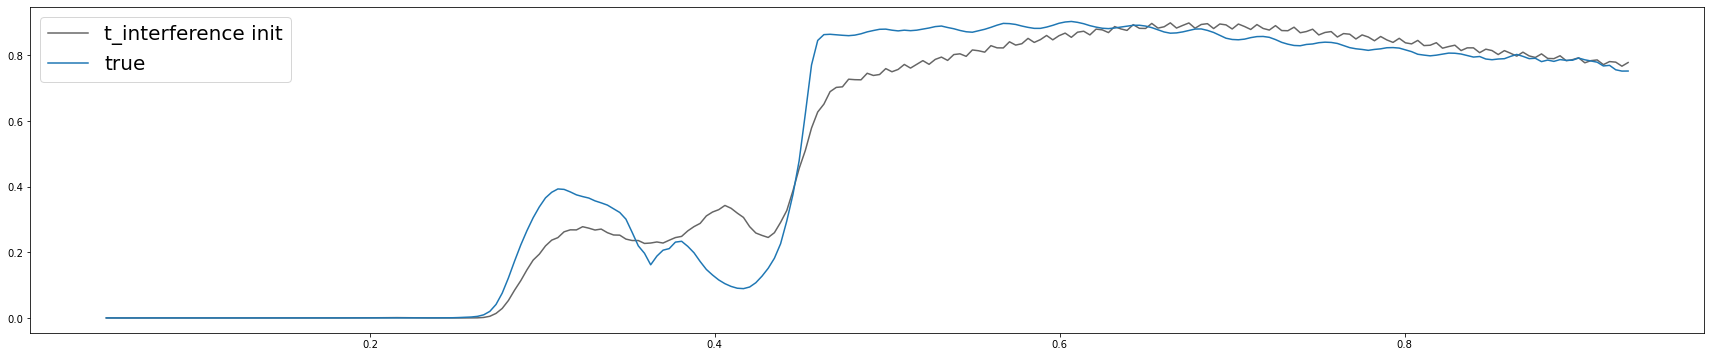

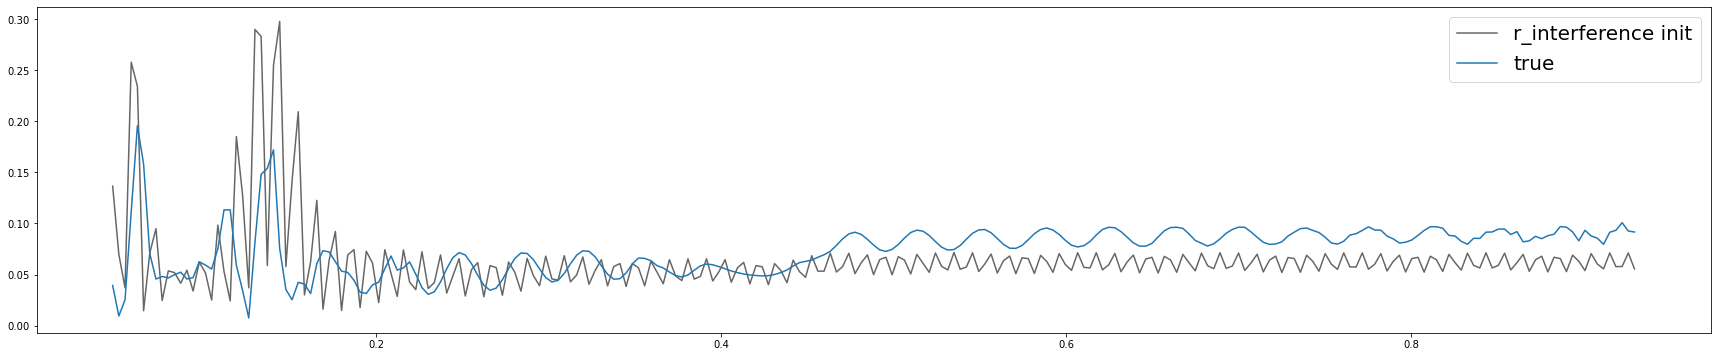

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


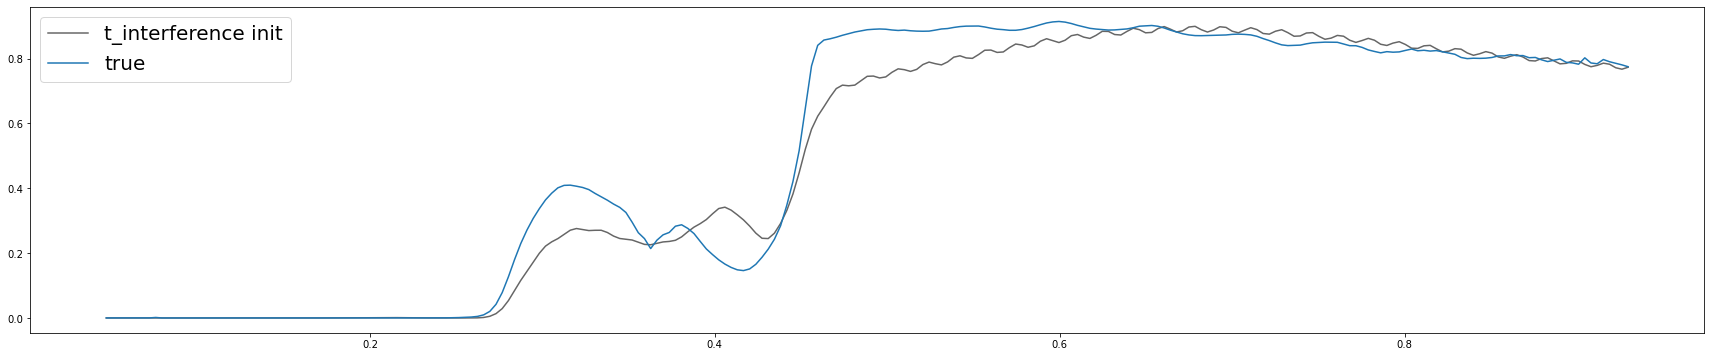

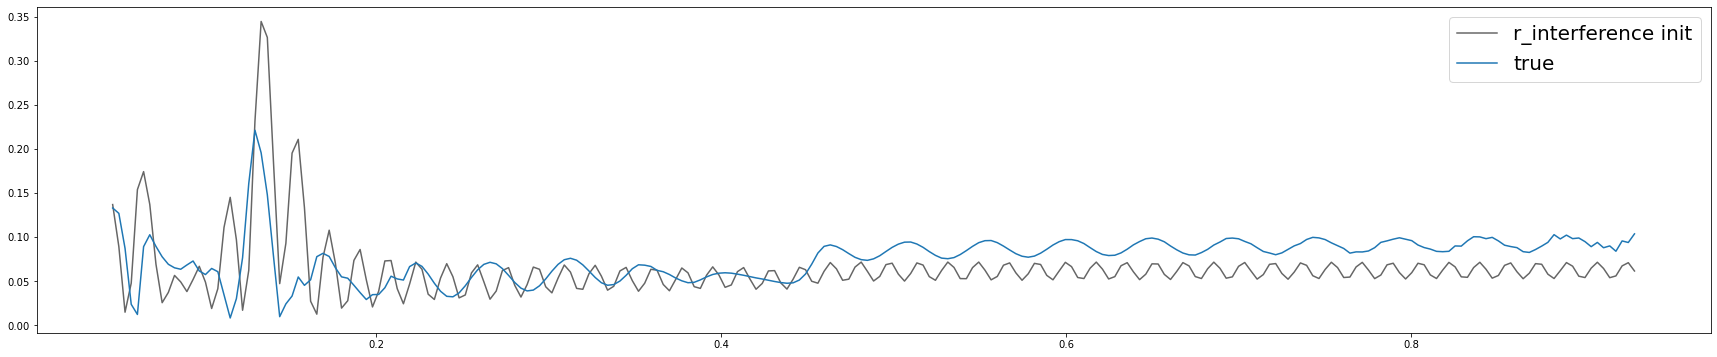

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.20001332e-03 3.20001152e-03 2.90001392e-03 2.60001274e-03]


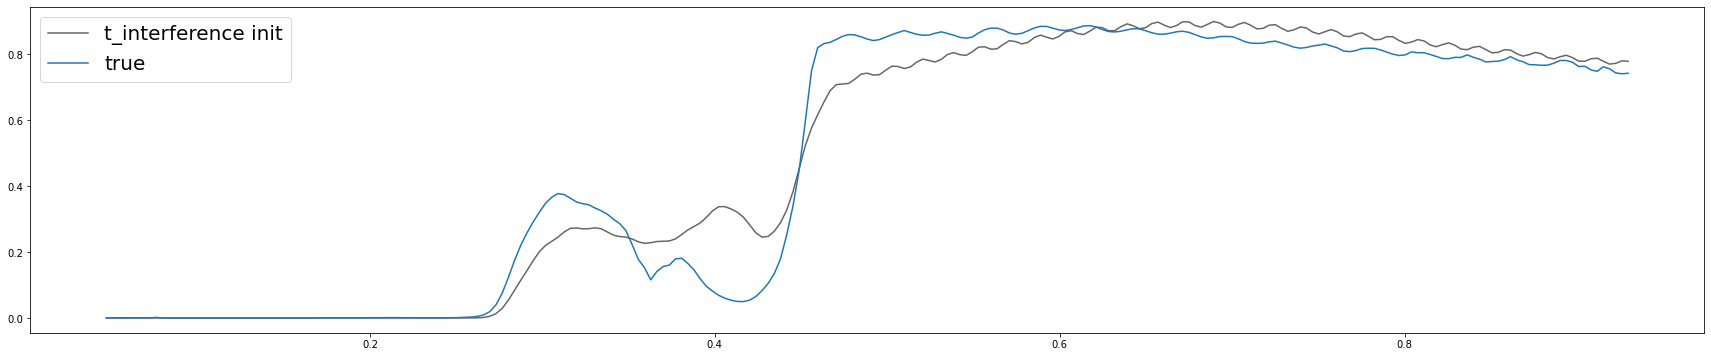

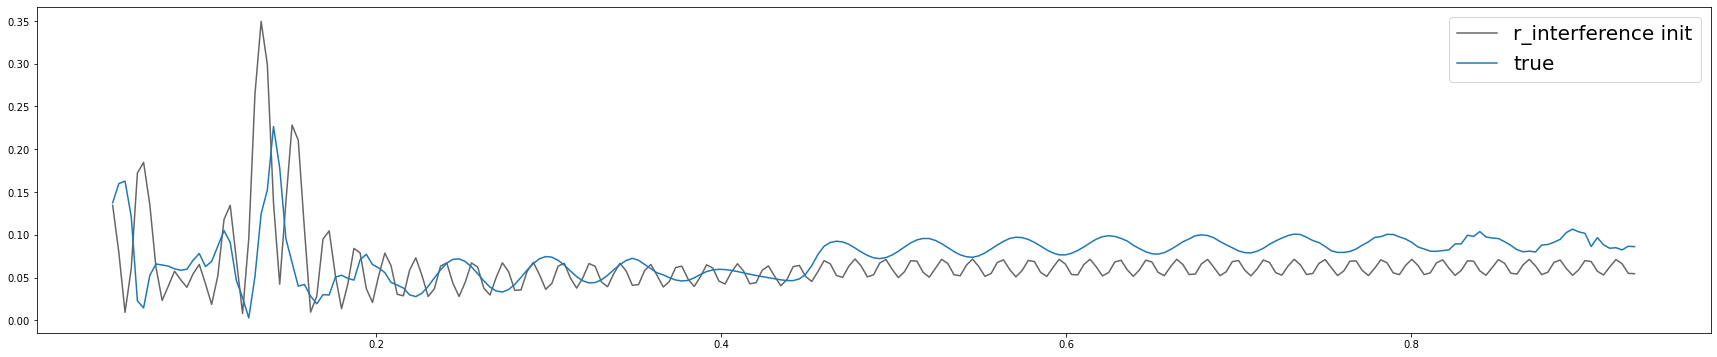

##################################### TURN 3 ######################################


In [6]:
DONE = False
EPS_INF = 2.4 #+ 1j*0.000001 
def r_interference(p, wavenumber):
    d = p[-1]
    n_rez = sqrt(hobb(p,wavenumber)+EPS_INF)
    wavenumber = wavenumber*10**7/1240
    r_01 = (n_rez - 1)/(n_rez+1)
    r_12 = (n_glass - n_rez)/(n_glass+n_rez)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi*wavenumber*n_rez*d))/(1 + r_01*r_12*exp(-4j*pi*wavenumber*n_rez*d))))
    return Reflection

def r_interference_back(p, wavenumber):
    d = p[-1]
    n_rez = sqrt(hobb(p,wavenumber)+EPS_INF)
    wavenumber = wavenumber*10**7/1240
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    r_01 = (1 - n_rez)/(n_rez+1)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi*wavenumber*n_rez*d))/(1 + r_01*r_12*exp(-4j*pi*wavenumber*n_rez*d))))
    return Reflection

def t_interference(p, wavenumber):
    d = p[-1]
    n_rez = sqrt(hobb(p,wavenumber)+EPS_INF)
    wavenumber = wavenumber*10**7/1240
    extinct = imag(n_rez)
    r_01 = (1 - n_rez)/(n_rez+1)
    r_12 = (n_rez - n_glass)/(n_glass+n_rez)
    t_01 = 2/(n_rez+1)
    t_12 = 2*n_rez/(n_rez+n_glass)
    t = np.square(np.abs((t_01*t_12*exp(-2j*pi*wavenumber*n_rez*d))/(1 + r_01*r_12*exp(-4j*pi*wavenumber*n_rez*d))))
    return t

def r_substrate(p, wavenumber):
    d_sub = 0.0258
    n_rez = sqrt(hobb(p,wavenumber)+EPS_INF)
    wavenumber = wavenumber*10**7/1240
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    R_01 = r_interference(p, wavenumber)
    R_10 = r_interference_back(p, wavenumber)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, wavenumber)
    T_10 = t_interference(p, wavenumber)
    exponent = exp(-4*pi*wavenumber*extinct*d_sub)
    return R_01 + T_01*R_12*T_10*exponent/(1-R_12*R_10*exponent)

def t_substrate(p, wavenumber):
    d_sub = 0.0258
    n_rez = sqrt(hobb(p,wavenumber)+EPS_INF)
    wavenumber = wavenumber*10**7/1240
    n_glass = np.sqrt(epsilon)
    extinct = np.imag(n_glass)
    R_10 = r_interference_back(p, wavenumber)
    R_12 = square(abs((n_glass - 1)/(n_glass + 1)))
    T_01 = t_interference(p, wavenumber)
    T_12 = square(abs(2*n_glass/(n_rez+n_glass)))
    exponent1 = exp(-4*pi*wavenumber*extinct*d_sub)
    exponent2 = exp(-8*pi*wavenumber*extinct*d_sub)
    Trans = T_01*T_12*exponent1/(1-R_12*R_10*exponent2)
    return Trans

def fit_both(p, wavenumber, R1, T1, R2, T2, R3, T3, R4, T4):
    p1 = np.append(p[:-4], p[-4])#p[:-3]|
    p2 = np.append(p[:-4], p[-3])
    p3 = np.append(p[:-4], p[-2])
    p4 = np.append(p[:-4], p[-1])
    Rdiff1 = r_substrate(p1, wavenumber) - R1
    Tdiff1 = t_substrate(p1, wavenumber) - T1
    Rdiff2 = r_substrate(p2, wavenumber) - R2
    Tdiff2 = t_substrate(p2, wavenumber) - T2
    Rdiff3 = r_substrate(p3, wavenumber) - R3
    Tdiff3 = t_substrate(p3, wavenumber) - T3
    Rdiff4 = r_substrate(p4, wavenumber) - R4
    Tdiff4 = t_substrate(p4, wavenumber) - T4
    both = np.concatenate((Tdiff1, Rdiff1, Tdiff2, Rdiff2, Tdiff3, Rdiff3, Tdiff4, Rdiff4))
    return both
 
    #            4     3      2      1 
d = np.array([32e-4, 32e-4, 29e-4, 26e-4])# initial guess for glass thicknes
inter_params = [] 
inter_params.extend([2e-11,2.2,0.016,1.25,
                     0.006,0.3,1e-10,0.029,
                     #0.026,0.5,1e-10,0.037,
                     0.0012,0.4,1e-14,0.0016,
                     0.000000073,0.6,1e-10,0.0835,
                     0.0000000177,0.83,1e-10,0.16,
                    ])
inter_params.extend(d)
arguments = [x]
truth = []
for sample in range(4):
    inter_trans = pd.read_csv(trans_data[sample]).iloc[:,1][:]  / trans_refr.iloc[:,1][:] 
    inter_trans = inter_trans[::15]
    inter_reflx = pd.read_csv(reflx_data[sample]).iloc[:,1][:]  / reflx_refr.iloc[:,1][:] 
    inter_reflx = inter_reflx[::15]
    truth.append([inter_reflx, inter_trans])
    arguments.extend([inter_reflx, inter_trans])
#inter_params = [1.16517966e-03, 4.35685347e-02, 9.00521824e-03, 2.13215579e-02, 1.93025193e-03, 5.71106836e-02 ,6.38634463e-03, 2.09097250e-03, 1.94194204e-03 ,1.39545168e-01, 1.91574699e-06 ,7.84668811e-03, 5.57725910e-03, 1.26058236e-01 ,3.96558318e-04 ,5.86142476e-03, 7.40084294e-04, 1.65742319e-01, 1.28747396e-03 ,6.37611495e-02 ,1.57980083e-04 ,2.49777820e-01, 1.41579666e-03, 1.47551375e-02 ,2.52747211e-05, 2.51904762e-01 ,1.00204217e-03, 6.77583135e-03, 5.47159961e-05, 3.69756774e-01, 1.49909299e-12, 3.37764834e-02, 1.95193649e-05, 4.32018216e-01, 1.18969824e-07, 1.33225285e-02]
#inter_params.extend(d)
upper_bounds = np.full(len(inter_params)-1, np.inf)
lower_bounds = np.zeros(len(inter_params)-1)
bounds = [(np.append(lower_bounds,(0.0001))),(np.append(upper_bounds,(0.6)))]

for turn in range(4):
    if turn != 0: inter_params = thin_res.x
    from scipy.optimize import least_squares
    thin_res = least_squares(fit_both,x0=inter_params, args=arguments, max_nfev = 1000, bounds = bounds)
    DONE = True
    fig = plt.figure(figsize=(60,6))
    n_rez = sqrt(hobb(inter_params[:-3],x)+1.8)
    plt.subplot(1,2,2)
    plt.plot(x, np.real(n_rez), label='$Re(n)$')
    plt.plot(x, np.imag(n_rez), label='$Im(n)$')
    plt.plot(x, np.zeros(len(n_rez)), label = "base")
    plt.legend()
    plt.xlabel("energy [eV]")
    plt.ylabel("n")
    plt.title('Refractive index')
    plt.savefig('Refractive.png')

    for sample in range(4):
        inter_reflx, inter_trans = truth[sample]
        inter_init = np.append(inter_params[:-4], inter_params[-sample-1])
        inter_fit = np.append(thin_res.x[:-4], thin_res.x[-sample-1])
        fig = plt.figure(figsize=(30,6))
        print(inter_params)
        plt.plot(x, t_substrate(inter_init, x) , label='t_interference init', color='black', alpha=0.6)
        plt.plot(x, inter_trans, label='true')
        #plt.plot(x, t_substrate(inter_fit, x), label = 't_interference model', linestyle = 'dashed')
        plt.legend(fontsize=20)
        plt.show()

        fig = plt.figure(figsize=(30,6))
        plt.plot(x, r_substrate(inter_init, x) , label='r_interference init', color='black', alpha=0.6)
        plt.plot(x, inter_reflx, label='true')
        #plt.plot(x, r_substrate(inter_fit, x), label = 'r_interference model', linestyle = 'dashed')
        plt.legend(fontsize=20)
        plt.show()
    print('##################################### TURN '+ str(turn)+' ######################################')


# Finalising

In [7]:
pip install pylatex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pylatex: filename=PyLaTeX-1.4.1-py3-none-any.whl size=42816 sha256=89eee6bf1a881b32f1a1c4f954c42e7079229419a486f9fb7746a7780737107e
  Stored in directory: /root/.cache/pip/wheels/4c/62/73/7688c83647b2103ef0c1b783730c8dc50fbbc3667eea6b1cb8
Successfully built pylatex
Note: you may need to restart the kernel to use updated packages.


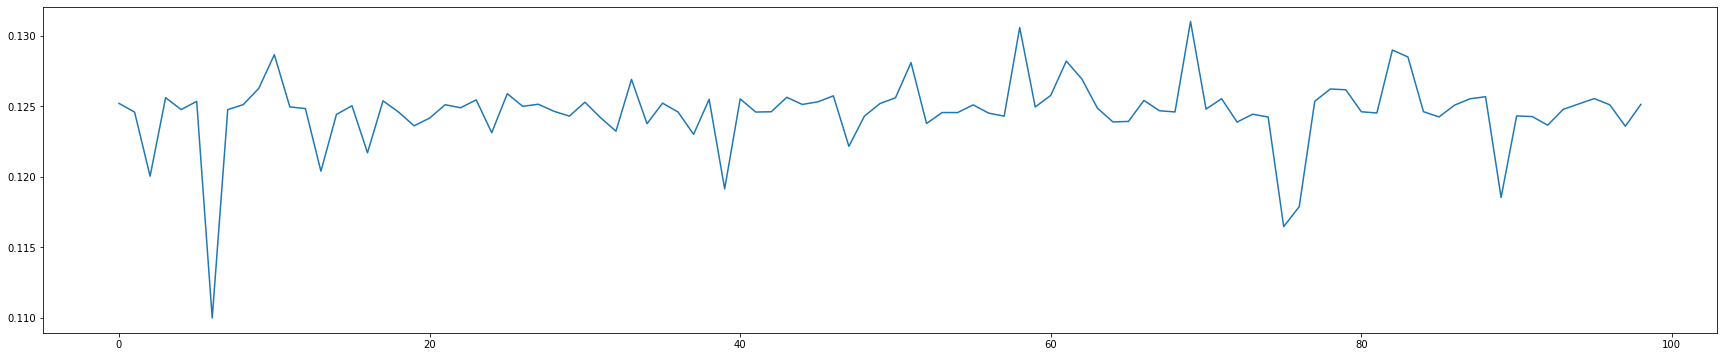

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 3.00000000e-04]


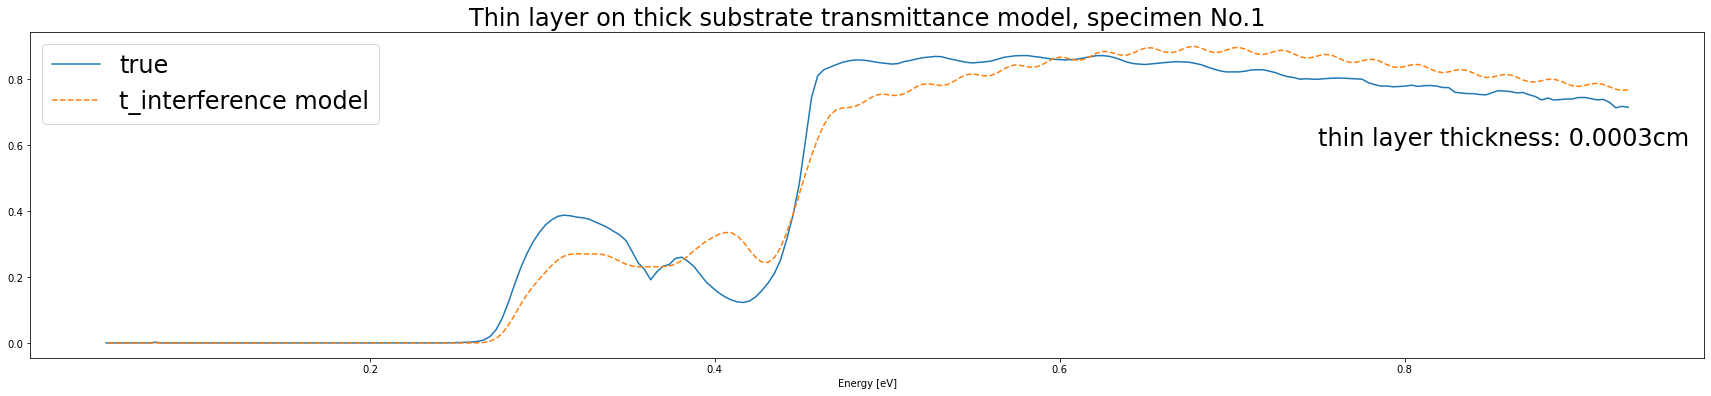

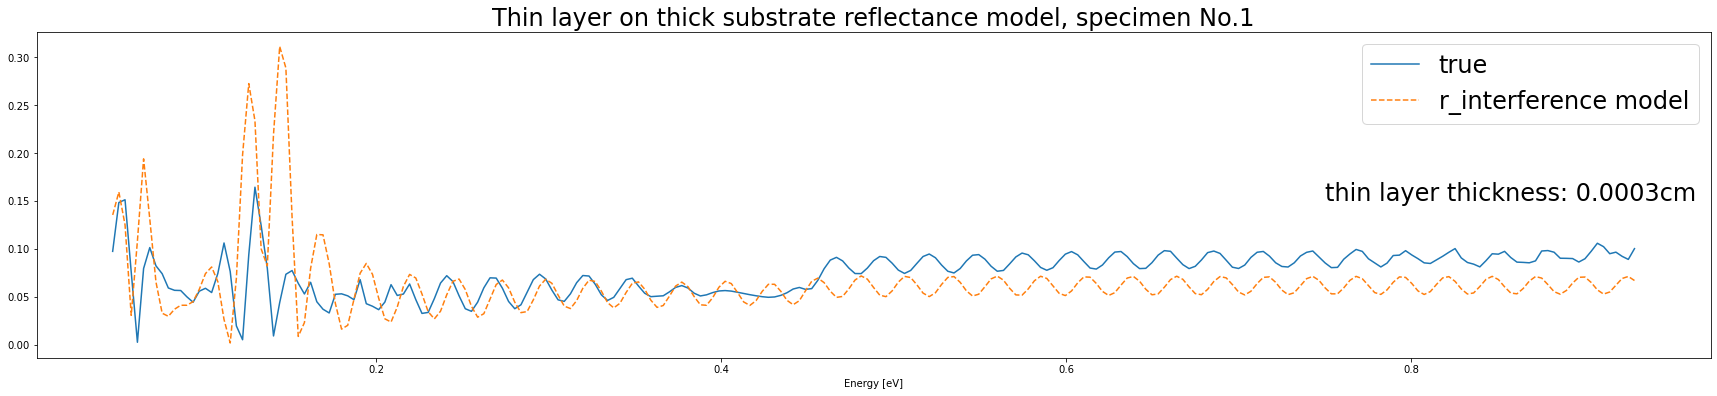

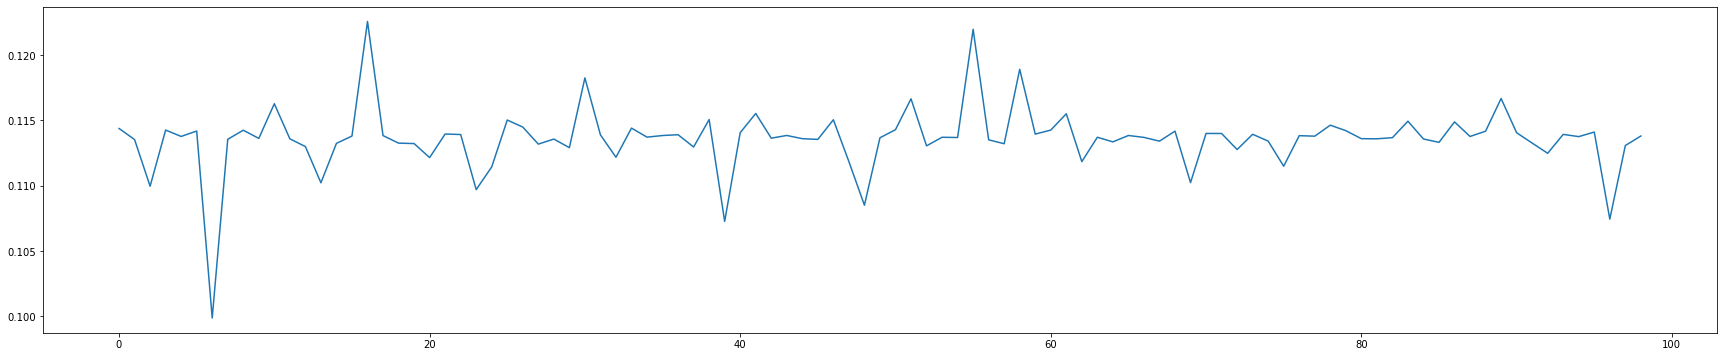

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 2.40000000e-03]


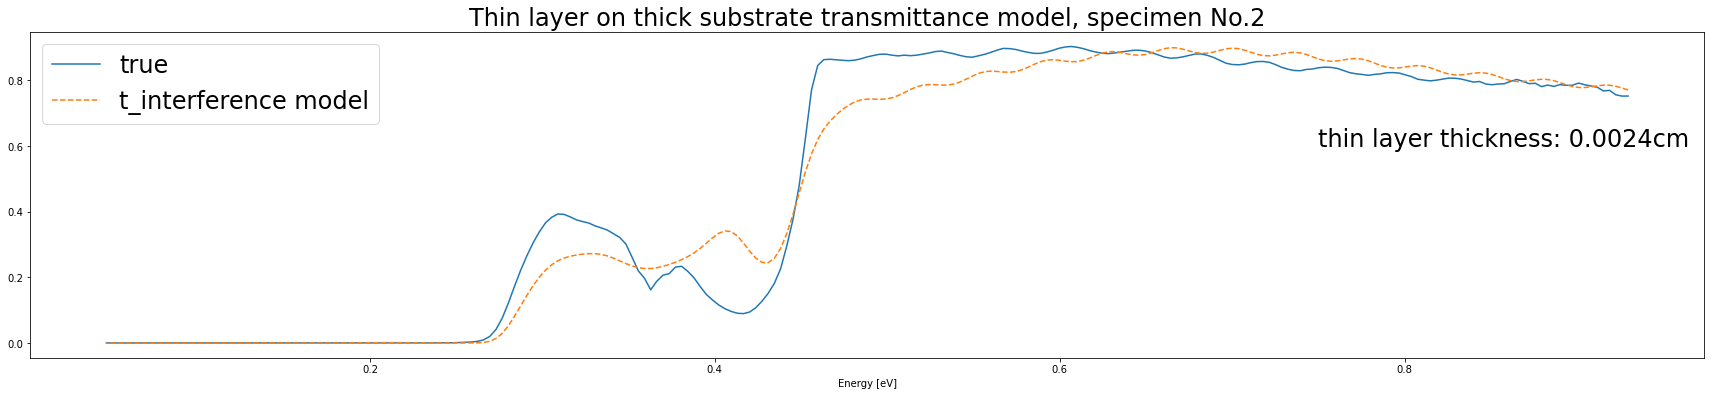

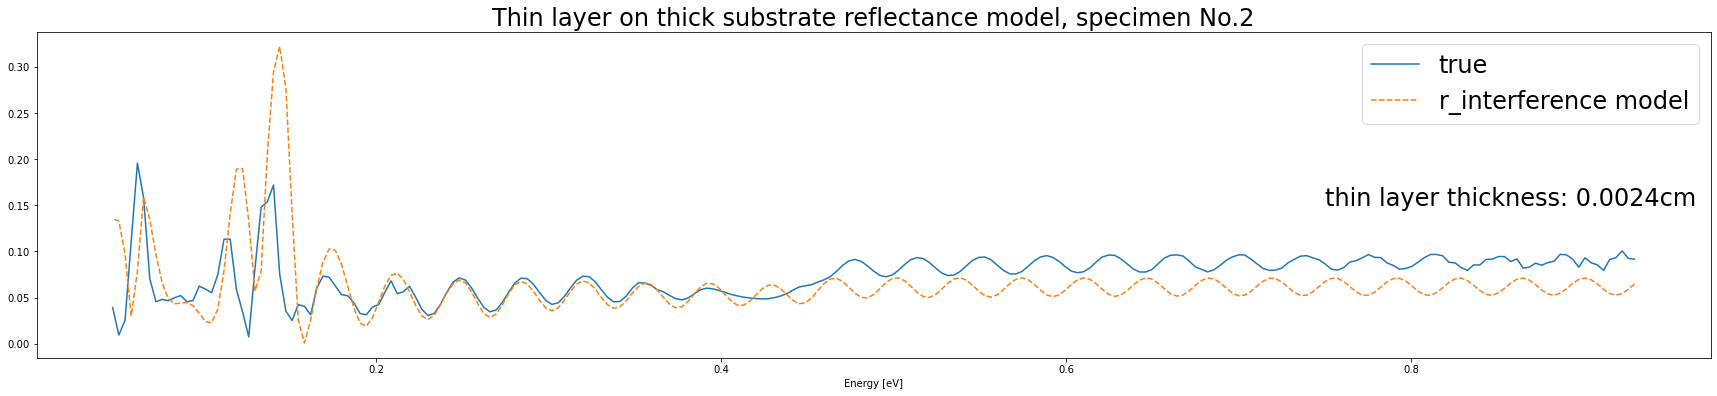

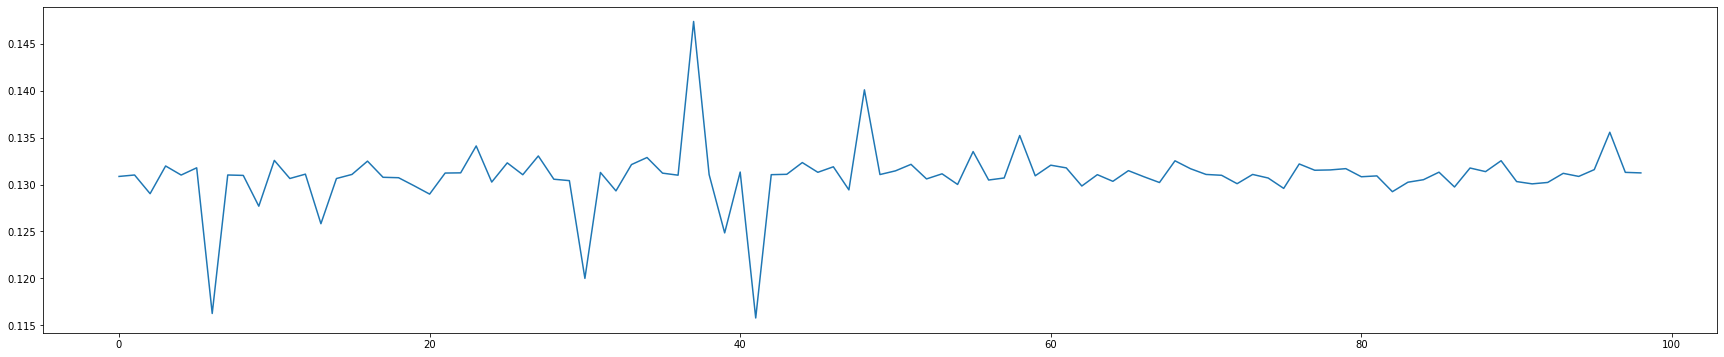

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 4.20000000e-03]


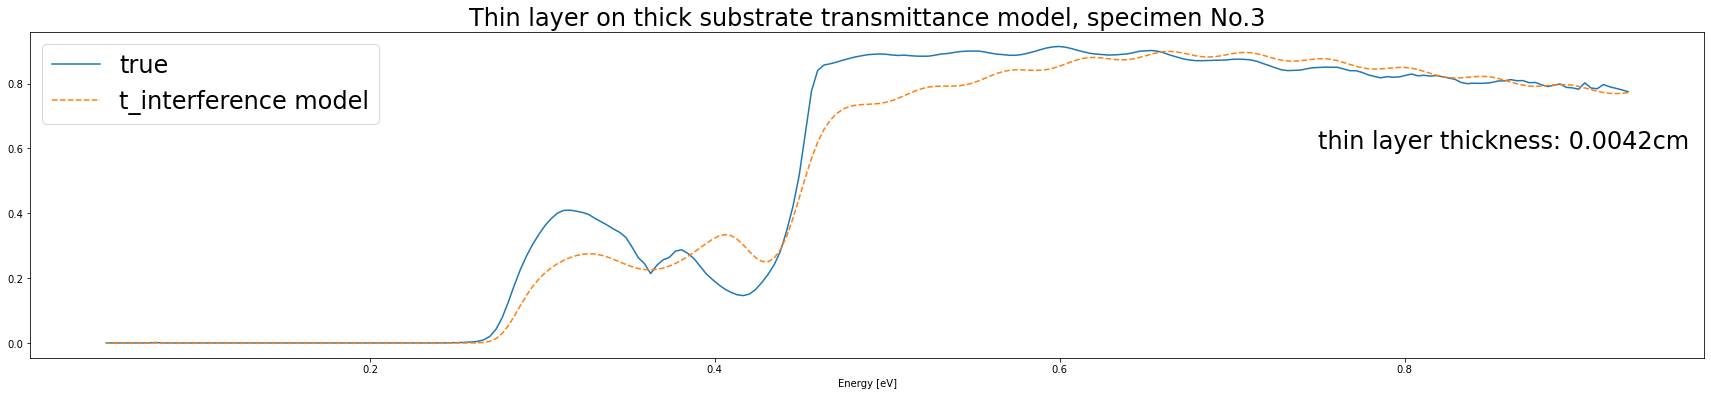

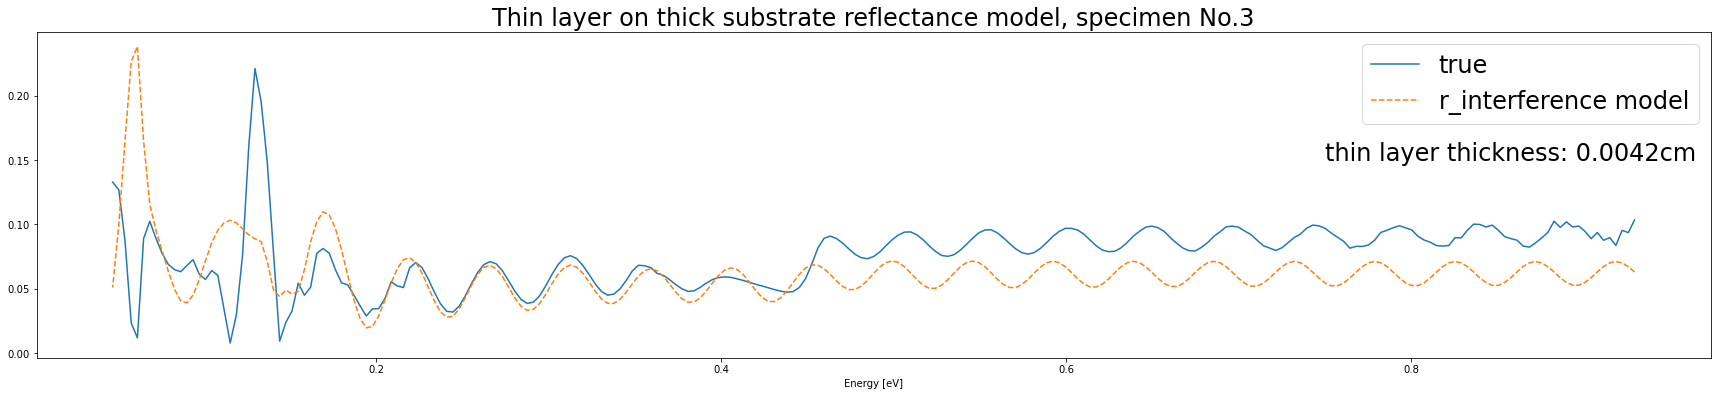

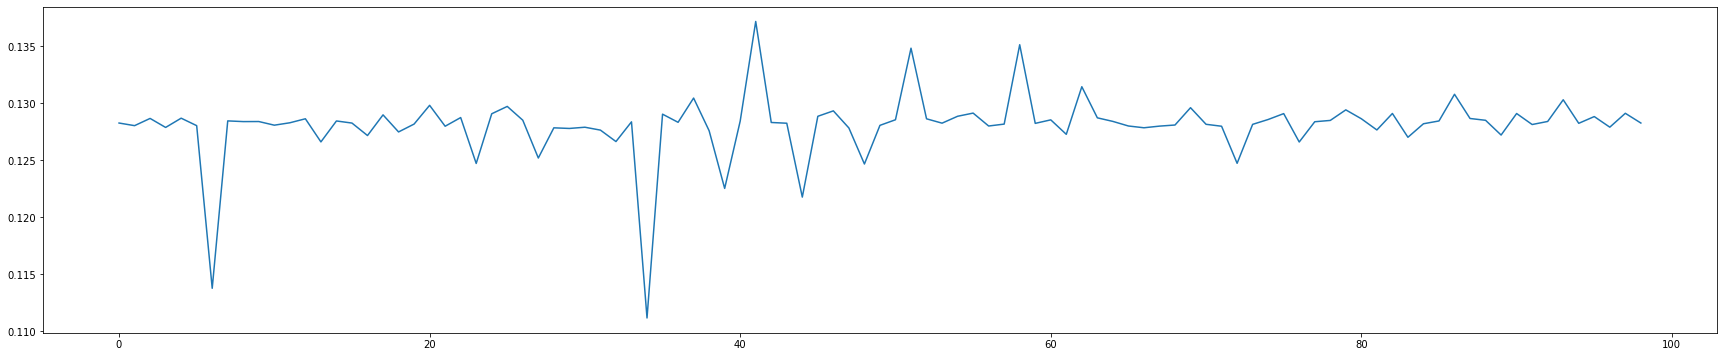

[1.00000000e-10 2.19884351e+00 1.59802645e-02 1.25000495e+00
 4.12222651e-01 1.00188080e-03 1.67658070e-10 1.56812413e-06
 2.20565713e-01 4.94557372e-01 9.07911057e-01 5.28277921e-01
 3.15858948e-01 3.84492374e-01 1.50676844e-01 1.96709348e-01
 1.29692115e-08 8.41626042e-01 5.81576409e-02 2.72927442e-01
 4.50000000e-03]


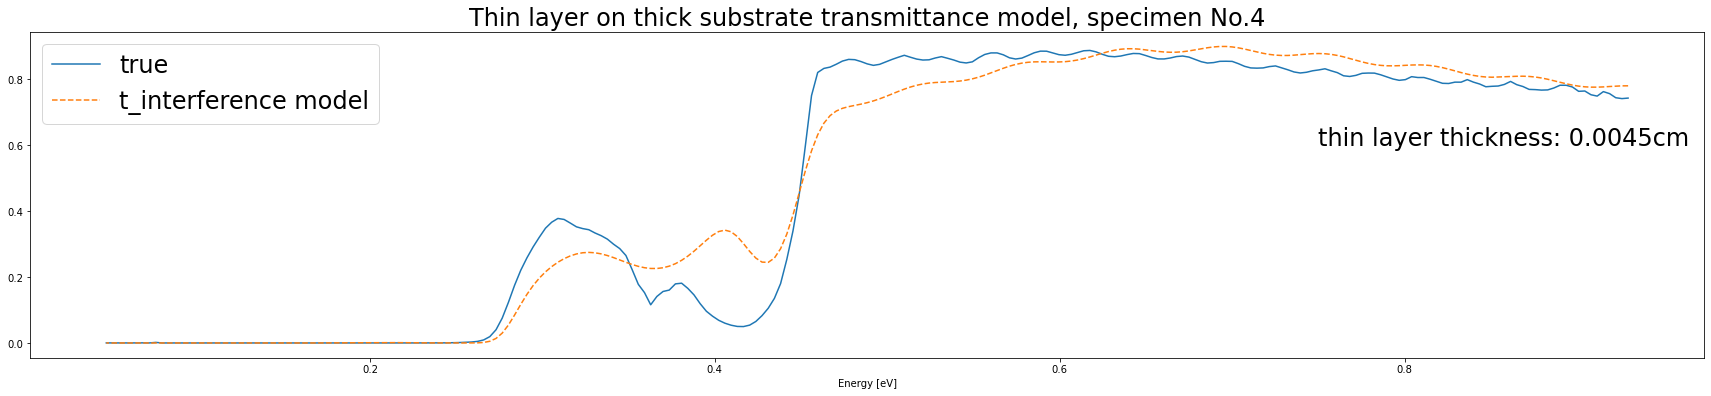

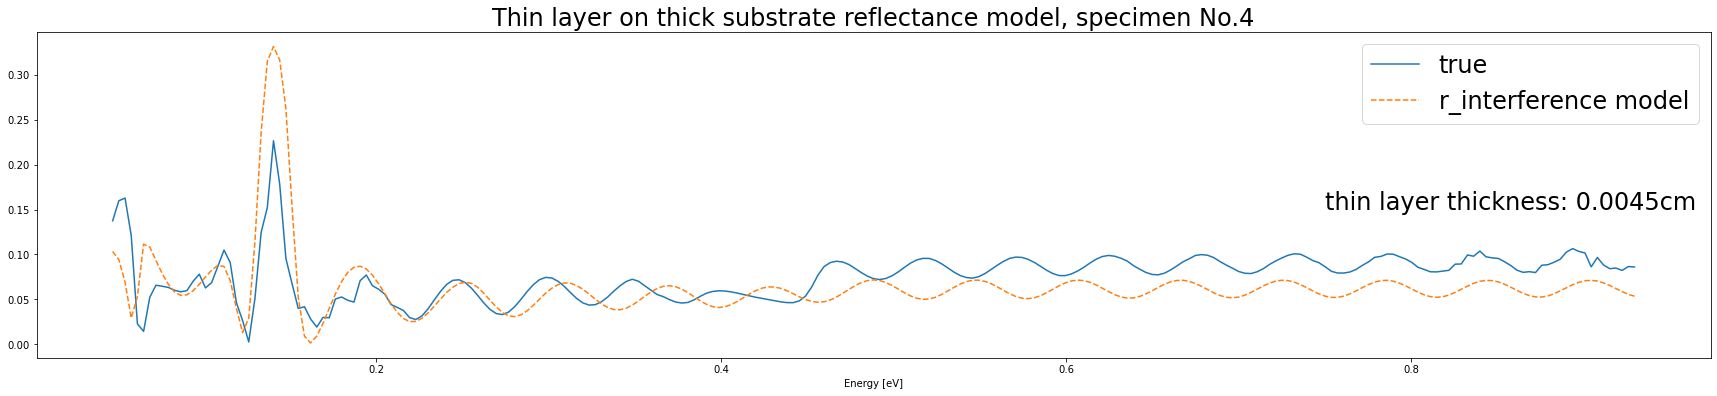

In [8]:
#136, 130, 92, 3
from pylatex import Document, Section, Subsection, Figure

geometry_options = {"tmargin": "1cm", "lmargin": "1cm"}
doc = Document(geometry_options=geometry_options)
d = np.array([45e-4, 42e-4, 24e-4, 3e-4])# initial guess for glass thicknes
for sample in range(4):
    inter_reflx, inter_trans = truth[sample]
    inter_init = np.append(inter_params[:-4], inter_params[-sample-1])
    inter_fit = np.append(thin_res.x[:-4], d[-sample-1])
    fig = plt.figure(figsize=(30,6))
    
    guess = np.array([sum(square(inter_reflx[:200] - r_substrate(np.append(thin_res.x[:-4], [b*1e-4]), x)[:200])) for b in range(1,100)])
    plt.plot(guess)
    plt.show()
    #best = np.where(guess < 0.12)[0]
    #print(best)
    
    for b in range(1):
        fig = plt.figure(figsize=(30,6))
        print(inter_fit)
        name = 'Thin layer on thick substrate transmittance model, specimen No.' + str(sample+1)
        plt.title(name, size = 24)
        #plt.plot(x, t_substrate(inter_init, x) , label='t_interference init', color='black', alpha=0.6)
        plt.text(0.75,0.6,'thin layer thickness: '+str(d[-sample-1]) + "cm", size = 24)
        plt.xlabel('Energy [eV]')
        plt.plot(x, inter_trans, label='true')
        plt.plot(x, t_substrate(inter_fit, x), label = 't_interference model', linestyle = 'dashed')
        plt.legend(fontsize=24)
        plt.savefig(name+'.png')#, bbox_inches='tight')
        plt.show()
        with doc.create(Figure(position='h!')) as trans_pic:
            trans_pic.add_image(name+'.png', width = '20cm')
            #trans_pic.add_caption(name)

        fig = plt.figure(figsize=(30,6))
        name = 'Thin layer on thick substrate reflectance model, specimen No.' + str(sample+1)
        plt.title(name, size = 24)
        plt.text(0.75,0.15,'thin layer thickness: '+str(d[-sample-1]) + "cm", size = 24)
        #plt.plot(x, r_substrate(inter_init, x) , label='r_interference init', color='black', alpha=0.6)
        plt.xlabel('Energy [eV]')
        plt.plot(x, inter_reflx, label='true')
        plt.plot(x, r_substrate(inter_fit, x), label = 'r_interference model', linestyle = 'dashed')
        plt.legend(fontsize=24)
        plt.savefig(name+'.png', bbox_inches='tight')
        plt.show()
        with doc.create(Figure(position='h!')) as reflx_pic:
            reflx_pic.add_image(name+'.png', width = '20cm')
            #reflx_pic.add_caption(name)
            
# Creating a pdf
#doc.generate_pdf('full', clean_tex=False)

In [9]:
print(list(inter_params))

[1e-10, 2.1988435128585953, 0.01598026451224776, 1.2500049546033796, 0.41222265107425515, 0.0010018808016143549, 1.6765806976598973e-10, 1.5681241286226054e-06, 0.220565713112519, 0.4945573723605589, 0.9079110574759497, 0.5282779207369148, 0.31585894819863236, 0.3844923740653011, 0.15067684411606544, 0.19670934788889552, 1.296921147696506e-08, 0.841626042335898, 0.05815764089415855, 0.2729274419102618, 0.0032000133207944603, 0.003200011515570213, 0.0029000139166542897, 0.0026000127427239137]
